In [2]:
!nvidia-smi

Wed Dec 17 05:25:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:0B:00.0  On |                  N/A |
| 39%   65C    P2            141W /  350W |    1542MiB /  24576MiB |     35%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [12]:
DATA_PATH = "/content/group_project/clean_data.csv"
SAVE_DIR = "/content/group_project/"
OBSERVATION_DAYS = 30
PREDICTION_DAYS = 31

In [13]:
def create_temporal_dataset(df, observation_days=30, prediction_days=31):
    df = df.copy()
    df['event_dt'] = pd.to_datetime(df['event_dt'])

    max_date = df['event_dt'].max()
    observation_end = max_date - pd.Timedelta(days=prediction_days)
    observation_start = observation_end - pd.Timedelta(days=observation_days)

    observation_data = df[
        (df['event_dt'] >= observation_start) &
        (df['event_dt'] < observation_end)
    ].copy()

    prediction_data = df[df['event_dt'] >= observation_end]

    active_in_observation = set(observation_data['device_id'].unique())
    active_in_prediction = set(prediction_data['device_id'].unique())
    churned_users = active_in_observation - active_in_prediction

    churn_labels = {uid: 1 if uid in churned_users else 0 for uid in active_in_observation}

    return observation_data, churn_labels

def create_sequences(df, user_ids):
    df = df.sort_values(['device_id', 'event_dt'])

    le_screen = LabelEncoder()
    le_feature = LabelEncoder()
    le_action = LabelEncoder()
    le_gender = LabelEncoder()

    df['screen_enc'] = le_screen.fit_transform(df['screen'].fillna('unknown'))
    df['feature_enc'] = le_feature.fit_transform(df['feature'].fillna('unknown'))
    df['action_enc'] = le_action.fit_transform(df['action'].fillna('unknown'))
    df['gender_enc'] = le_gender.fit_transform(df['gender'].fillna('unknown'))

    df['hour'] = df['event_dt'].dt.hour / 24.0
    df['day_of_week'] = df['event_dt'].dt.dayofweek / 7.0
    df['is_weekend'] = (df['event_dt'].dt.dayofweek >= 5).astype(float)
    df['time_diff'] = df.groupby('device_id')['event_dt'].diff().dt.total_seconds() / 3600
    df['time_diff'] = df['time_diff'].fillna(0).clip(0, 24) / 24.0
    df['age_norm'] = (df['age'] - df['age'].mean()) / df['age'].std()
    df['age_norm'] = df['age_norm'].fillna(0)

    feature_cols = [
        'screen_enc', 'feature_enc', 'action_enc', 'gender_enc',
        'hour', 'day_of_week', 'is_weekend', 'time_diff', 'age_norm'
    ]

    sequences = []
    sequence_user_ids = []

    for device_id in user_ids:
        user_data = df[df['device_id'] == device_id]
        if len(user_data) > 0:
            seq = user_data[feature_cols].values.astype(np.float32)
            sequences.append(seq)
            sequence_user_ids.append(device_id)

    return sequences, sequence_user_ids, len(feature_cols)

class SequenceDataset(Dataset):
    def __init__(self, sequences, max_len=50):
        self.sequences = sequences
        self.max_len = max_len

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]

        if len(seq) > self.max_len:
            seq = seq[-self.max_len:]
        else:
            pad = np.zeros((self.max_len - len(seq), seq.shape[1]))
            seq = np.vstack([pad, seq])

        mask = torch.ones(self.max_len)
        if len(self.sequences[idx]) < self.max_len:
            mask[:self.max_len - len(self.sequences[idx])] = 0

        return torch.FloatTensor(seq), mask

class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, embedding_dim=64):
        super(LSTMEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                           batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, embedding_dim)

    def forward(self, x, mask):
        lstm_out, _ = self.lstm(x)
        mask_expanded = mask.unsqueeze(-1).expand_as(lstm_out)
        masked_out = lstm_out * mask_expanded
        pooled = torch.sum(masked_out, dim=1) / torch.sum(mask_expanded, dim=1).clamp(min=1)
        embedding = self.fc(pooled)
        return embedding

class GRUEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, embedding_dim=64):
        super(GRUEncoder, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers,
                         batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, embedding_dim)

    def forward(self, x, mask):
        gru_out, _ = self.gru(x)
        mask_expanded = mask.unsqueeze(-1).expand_as(gru_out)
        masked_out = gru_out * mask_expanded
        pooled = torch.sum(masked_out, dim=1) / torch.sum(mask_expanded, dim=1).clamp(min=1)
        embedding = self.fc(pooled)
        return embedding

class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, num_heads=4, embedding_dim=64):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads,
                                                   dim_feedforward=hidden_dim*4, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, embedding_dim)

    def forward(self, x, mask):
        x = self.embedding(x)
        attn_mask = ~mask.bool()
        x = self.transformer(x, src_key_padding_mask=attn_mask)
        mask_expanded = mask.unsqueeze(-1).expand_as(x)
        masked_out = x * mask_expanded
        pooled = torch.sum(masked_out, dim=1) / torch.sum(mask_expanded, dim=1).clamp(min=1)
        embedding = self.fc(pooled)
        return embedding

def train_encoder(model, dataloader, epochs=20, device='cuda'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for sequences, masks in dataloader:
            sequences, masks = sequences.to(device), masks.to(device)

            optimizer.zero_grad()
            embeddings = model(sequences, masks)

            batch_size = embeddings.size(0)
            targets = torch.arange(batch_size, device=device)

            sim_matrix = torch.matmul(embeddings, embeddings.t())
            sim_matrix = sim_matrix / 0.07

            loss = F.cross_entropy(sim_matrix, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(dataloader):.4f}")

    return model

def extract_embeddings(model, dataloader, device='cuda'):
    model.eval()
    embeddings = []

    with torch.no_grad():
        for sequences, masks in dataloader:
            sequences, masks = sequences.to(device), masks.to(device)
            emb = model(sequences, masks)
            embeddings.append(emb.cpu().numpy())

    return np.vstack(embeddings)

def cluster_users(embeddings, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(embeddings)
    return clusters, kmeans

def visualize_clusters_2d(embeddings, clusters, churn_labels, method='pca', save_path=None):
    if method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        reduced = reducer.fit_transform(embeddings)
        title_suffix = f"(PCA, var={reducer.explained_variance_ratio_.sum():.2%})"
    else:
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        reduced = reducer.fit_transform(embeddings)
        title_suffix = "(t-SNE)"

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    scatter1 = axes[0].scatter(reduced[:, 0], reduced[:, 1], c=clusters,
                               cmap='tab10', alpha=0.6, s=20)
    axes[0].set_title(f'User Clusters {title_suffix}', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Component 1')
    axes[0].set_ylabel('Component 2')
    plt.colorbar(scatter1, ax=axes[0], label='Cluster')

    scatter2 = axes[1].scatter(reduced[:, 0], reduced[:, 1], c=churn_labels,
                               cmap='RdYlGn_r', alpha=0.6, s=20)
    axes[1].set_title(f'Churn Distribution {title_suffix}', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Component 1')
    axes[1].set_ylabel('Component 2')
    plt.colorbar(scatter2, ax=axes[1], label='Churned', ticks=[0, 1])

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    return reduced

def visualize_cluster_statistics(clusters, churn_labels, save_path=None):
    df = pd.DataFrame({'cluster': clusters, 'churn': churn_labels})

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    cluster_sizes = df['cluster'].value_counts().sort_index()
    axes[0, 0].bar(cluster_sizes.index, cluster_sizes.values, color='steelblue', alpha=0.7)
    axes[0, 0].set_title('Users per Cluster', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Cluster')
    axes[0, 0].set_ylabel('Number of Users')
    axes[0, 0].grid(axis='y', alpha=0.3)

    churn_by_cluster = df.groupby('cluster')['churn'].agg(['mean', 'count'])
    axes[0, 1].bar(churn_by_cluster.index, churn_by_cluster['mean'] * 100,
                   color='coral', alpha=0.7)
    axes[0, 1].set_title('Churn Rate by Cluster', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Cluster')
    axes[0, 1].set_ylabel('Churn Rate (%)')
    axes[0, 1].axhline(y=df['churn'].mean() * 100, color='red', linestyle='--',
                       label=f'Overall: {df["churn"].mean()*100:.1f}%')
    axes[0, 1].legend()
    axes[0, 1].grid(axis='y', alpha=0.3)

    cluster_churn = df.groupby(['cluster', 'churn']).size().unstack(fill_value=0)
    cluster_churn.plot(kind='bar', stacked=True, ax=axes[1, 0],
                       color=['lightgreen', 'salmon'], alpha=0.7)
    axes[1, 0].set_title('Churn Distribution by Cluster', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Cluster')
    axes[1, 0].set_ylabel('Number of Users')
    axes[1, 0].legend(['Retained', 'Churned'])
    axes[1, 0].grid(axis='y', alpha=0.3)

    cluster_churn_pct = cluster_churn.div(cluster_churn.sum(axis=1), axis=0) * 100
    cluster_churn_pct.plot(kind='bar', stacked=True, ax=axes[1, 1],
                          color=['lightgreen', 'salmon'], alpha=0.7)
    axes[1, 1].set_title('Churn Proportion by Cluster', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Cluster')
    axes[1, 1].set_ylabel('Percentage (%)')
    axes[1, 1].legend(['Retained', 'Churned'])
    axes[1, 1].grid(axis='y', alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

def analyze_cluster_profiles(df, user_ids, clusters, churn_labels, save_path=None):
    cluster_profiles = []

    for cluster_id in sorted(np.unique(clusters)):
        cluster_users = [user_ids[i] for i in range(len(user_ids)) if clusters[i] == cluster_id]
        cluster_data = df[df['device_id'].isin(cluster_users)]

        profile = {
            'cluster': cluster_id,
            'n_users': len(cluster_users),
            'churn_rate': np.mean([churn_labels[i] for i in range(len(user_ids)) if clusters[i] == cluster_id]),
            'avg_events': cluster_data.groupby('device_id').size().mean(),
            'avg_sessions': cluster_data.groupby('device_id')['session_id'].nunique().mean(),
            'avg_age': cluster_data.groupby('device_id')['age'].first().mean(),
            'pct_female': (cluster_data.groupby('device_id')['gender'].first() == 'F').mean() * 100,
            'top_screen': cluster_data['screen'].mode()[0] if len(cluster_data) > 0 else 'N/A',
            'top_feature': cluster_data['feature'].mode()[0] if len(cluster_data) > 0 else 'N/A',
        }
        cluster_profiles.append(profile)

    profiles_df = pd.DataFrame(cluster_profiles)

    print("\nCluster Profiles:")
    print("="*100)
    print(profiles_df.to_string(index=False))
    print("="*100)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    axes[0, 0].bar(profiles_df['cluster'], profiles_df['avg_events'], color='steelblue', alpha=0.7)
    axes[0, 0].set_title('Average Events per User', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Cluster')
    axes[0, 0].set_ylabel('Events')
    axes[0, 0].grid(axis='y', alpha=0.3)

    axes[0, 1].bar(profiles_df['cluster'], profiles_df['avg_sessions'], color='green', alpha=0.7)
    axes[0, 1].set_title('Average Sessions per User', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Cluster')
    axes[0, 1].set_ylabel('Sessions')
    axes[0, 1].grid(axis='y', alpha=0.3)

    axes[1, 0].bar(profiles_df['cluster'], profiles_df['avg_age'], color='purple', alpha=0.7)
    axes[1, 0].set_title('Average Age', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Cluster')
    axes[1, 0].set_ylabel('Age')
    axes[1, 0].grid(axis='y', alpha=0.3)

    axes[1, 1].bar(profiles_df['cluster'], profiles_df['pct_female'], color='coral', alpha=0.7)
    axes[1, 1].set_title('Percentage Female', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Cluster')
    axes[1, 1].set_ylabel('Female (%)')
    axes[1, 1].grid(axis='y', alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    return profiles_df

def compare_models(embeddings_dict, clusters_dict, churn_labels, save_path=None):
    results = []

    for model_name, embeddings in embeddings_dict.items():
        clusters = clusters_dict[model_name]
        df = pd.DataFrame({'cluster': clusters, 'churn': churn_labels})

        cluster_sizes = df['cluster'].value_counts()
        churn_by_cluster = df.groupby('cluster')['churn'].mean()

        results.append({
            'model': model_name,
            'n_clusters': len(np.unique(clusters)),
            'min_cluster_size': cluster_sizes.min(),
            'max_cluster_size': cluster_sizes.max(),
            'churn_std': churn_by_cluster.std(),
            'churn_range': churn_by_cluster.max() - churn_by_cluster.min(),
        })

    results_df = pd.DataFrame(results)

    print("\nModel Comparison:")
    print("="*80)
    print(results_df.to_string(index=False))
    print("="*80)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    x = np.arange(len(results_df))
    width = 0.35

    axes[0].bar(x, results_df['churn_std'], width, label='Churn Std', alpha=0.7)
    axes[0].set_xlabel('Model')
    axes[0].set_ylabel('Standard Deviation')
    axes[0].set_title('Churn Rate Variation Between Clusters', fontsize=12, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(results_df['model'])
    axes[0].grid(axis='y', alpha=0.3)

    axes[1].bar(x, results_df['churn_range'], width, color='coral', alpha=0.7)
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('Range')
    axes[1].set_title('Churn Rate Range Between Clusters', fontsize=12, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(results_df['model'])
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    return results_df

df = pd.read_csv(DATA_PATH)
print(f"Loaded {len(df):,} events")

observation_data, churn_labels = create_temporal_dataset(df, OBSERVATION_DAYS, PREDICTION_DAYS)
user_ids = list(churn_labels.keys())

print(f"Users: {len(user_ids):,}")
print(f"Churn rate: {np.mean(list(churn_labels.values())):.1%}")

print("\nCreating sequences...")
sequences, sequence_user_ids, input_dim = create_sequences(observation_data, user_ids)
print(f"Sequences: {len(sequences):,}")
print(f"Input dim: {input_dim}")

churn_array = np.array([churn_labels[uid] for uid in sequence_user_ids])

dataset = SequenceDataset(sequences, max_len=50)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\nDevice: {device}")

print("\n" + "="*80)
print("READY TO TRAIN ENCODERS")
print("="*80)
print("\nRun:")
print("  embeddings_lstm, clusters_lstm = train_and_cluster_lstm()")
print("  embeddings_gru, clusters_gru = train_and_cluster_gru()")
print("  embeddings_transformer, clusters_transformer = train_and_cluster_transformer()")
print("  compare_all_models()")

def train_and_cluster_lstm(n_clusters=5):
    print("\n" + "="*80)
    print("TRAINING LSTM ENCODER")
    print("="*80)

    model = LSTMEncoder(input_dim, hidden_dim=128, num_layers=2, embedding_dim=64)
    model = train_encoder(model, dataloader, epochs=20, device=device)

    print("\nExtracting embeddings...")
    embeddings = extract_embeddings(model, dataloader, device=device)

    print(f"Clustering into {n_clusters} clusters...")
    clusters, kmeans = cluster_users(embeddings, n_clusters=n_clusters)

    print("\nVisualizing...")
    visualize_clusters_2d(embeddings, clusters, churn_array, method='pca',
                         save_path=f'{SAVE_DIR}lstm_clusters_pca.png')
    visualize_clusters_2d(embeddings, clusters, churn_array, method='tsne',
                         save_path=f'{SAVE_DIR}lstm_clusters_tsne.png')
    visualize_cluster_statistics(clusters, churn_array,
                                 save_path=f'{SAVE_DIR}lstm_cluster_stats.png')
    profiles = analyze_cluster_profiles(observation_data, sequence_user_ids, clusters, churn_array,
                                       save_path=f'{SAVE_DIR}lstm_cluster_profiles.png')

    return embeddings, clusters

def train_and_cluster_gru(n_clusters=5):
    print("\n" + "="*80)
    print("TRAINING GRU ENCODER")
    print("="*80)

    model = GRUEncoder(input_dim, hidden_dim=128, num_layers=2, embedding_dim=64)
    model = train_encoder(model, dataloader, epochs=20, device=device)

    print("\nExtracting embeddings...")
    embeddings = extract_embeddings(model, dataloader, device=device)

    print(f"Clustering into {n_clusters} clusters...")
    clusters, kmeans = cluster_users(embeddings, n_clusters=n_clusters)

    print("\nVisualizing...")
    visualize_clusters_2d(embeddings, clusters, churn_array, method='pca',
                         save_path=f'{SAVE_DIR}gru_clusters_pca.png')
    visualize_clusters_2d(embeddings, clusters, churn_array, method='tsne',
                         save_path=f'{SAVE_DIR}gru_clusters_tsne.png')
    visualize_cluster_statistics(clusters, churn_array,
                                 save_path=f'{SAVE_DIR}gru_cluster_stats.png')
    profiles = analyze_cluster_profiles(observation_data, sequence_user_ids, clusters, churn_array,
                                       save_path=f'{SAVE_DIR}gru_cluster_profiles.png')

    return embeddings, clusters

def train_and_cluster_transformer(n_clusters=5):
    print("\n" + "="*80)
    print("TRAINING TRANSFORMER ENCODER")
    print("="*80)

    model = TransformerEncoder(input_dim, hidden_dim=128, num_layers=2, num_heads=4, embedding_dim=64)
    model = train_encoder(model, dataloader, epochs=20, device=device)

    print("\nExtracting embeddings...")
    embeddings = extract_embeddings(model, dataloader, device=device)

    print(f"Clustering into {n_clusters} clusters...")
    clusters, kmeans = cluster_users(embeddings, n_clusters=n_clusters)

    print("\nVisualizing...")
    visualize_clusters_2d(embeddings, clusters, churn_array, method='pca',
                         save_path=f'{SAVE_DIR}transformer_clusters_pca.png')
    visualize_clusters_2d(embeddings, clusters, churn_array, method='tsne',
                         save_path=f'{SAVE_DIR}transformer_clusters_tsne.png')
    visualize_cluster_statistics(clusters, churn_array,
                                 save_path=f'{SAVE_DIR}transformer_cluster_stats.png')
    profiles = analyze_cluster_profiles(observation_data, sequence_user_ids, clusters, churn_array,
                                       save_path=f'{SAVE_DIR}transformer_cluster_profiles.png')

    return embeddings, clusters

def compare_all_models():
    print("\n" + "="*80)
    print("TRAINING ALL MODELS")
    print("="*80)

    embeddings_lstm, clusters_lstm = train_and_cluster_lstm()
    embeddings_gru, clusters_gru = train_and_cluster_gru()
    embeddings_transformer, clusters_transformer = train_and_cluster_transformer()

    embeddings_dict = {
        'LSTM': embeddings_lstm,
        'GRU': embeddings_gru,
        'Transformer': embeddings_transformer
    }

    clusters_dict = {
        'LSTM': clusters_lstm,
        'GRU': clusters_gru,
        'Transformer': clusters_transformer
    }

    comparison = compare_models(embeddings_dict, clusters_dict, churn_array,
                               save_path=f'{SAVE_DIR}model_comparison.png')

    return embeddings_dict, clusters_dict, comparison

Loaded 3,360,650 events
Users: 135,860
Churn rate: 43.6%

Creating sequences...
Sequences: 135,860
Input dim: 9

Device: cuda

READY TO TRAIN ENCODERS

Run:
  embeddings_lstm, clusters_lstm = train_and_cluster_lstm()
  embeddings_gru, clusters_gru = train_and_cluster_gru()
  embeddings_transformer, clusters_transformer = train_and_cluster_transformer()
  compare_all_models()



TRAINING LSTM ENCODER
Epoch 5/20 | Loss: 0.0555
Epoch 10/20 | Loss: 0.0292
Epoch 15/20 | Loss: 0.0237
Epoch 20/20 | Loss: 0.0214

Extracting embeddings...
Clustering into 5 clusters...

Visualizing...


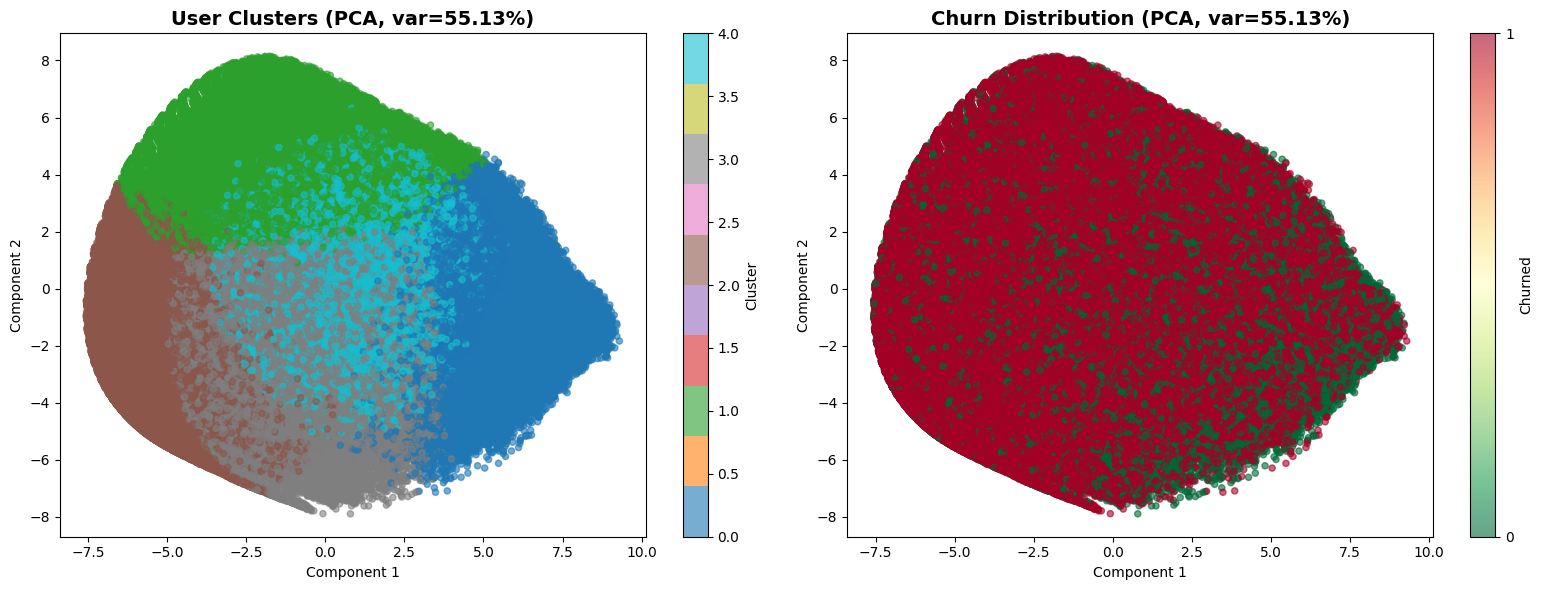

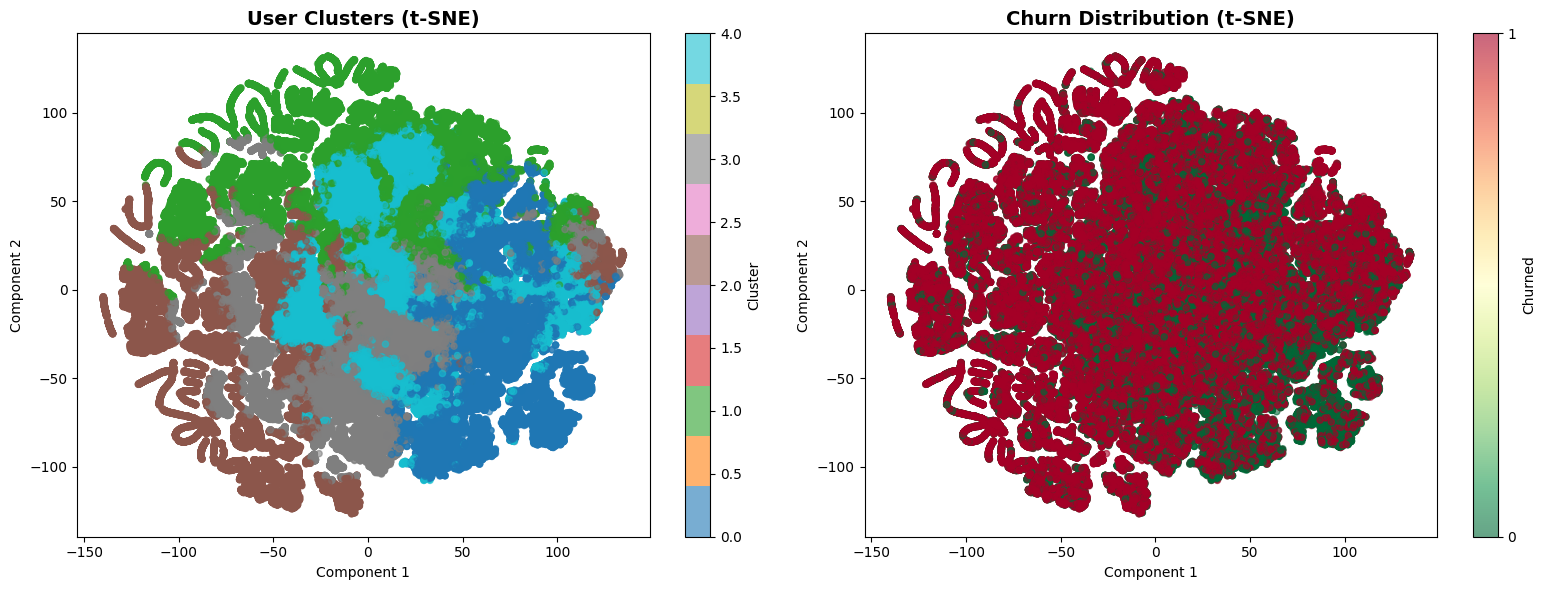

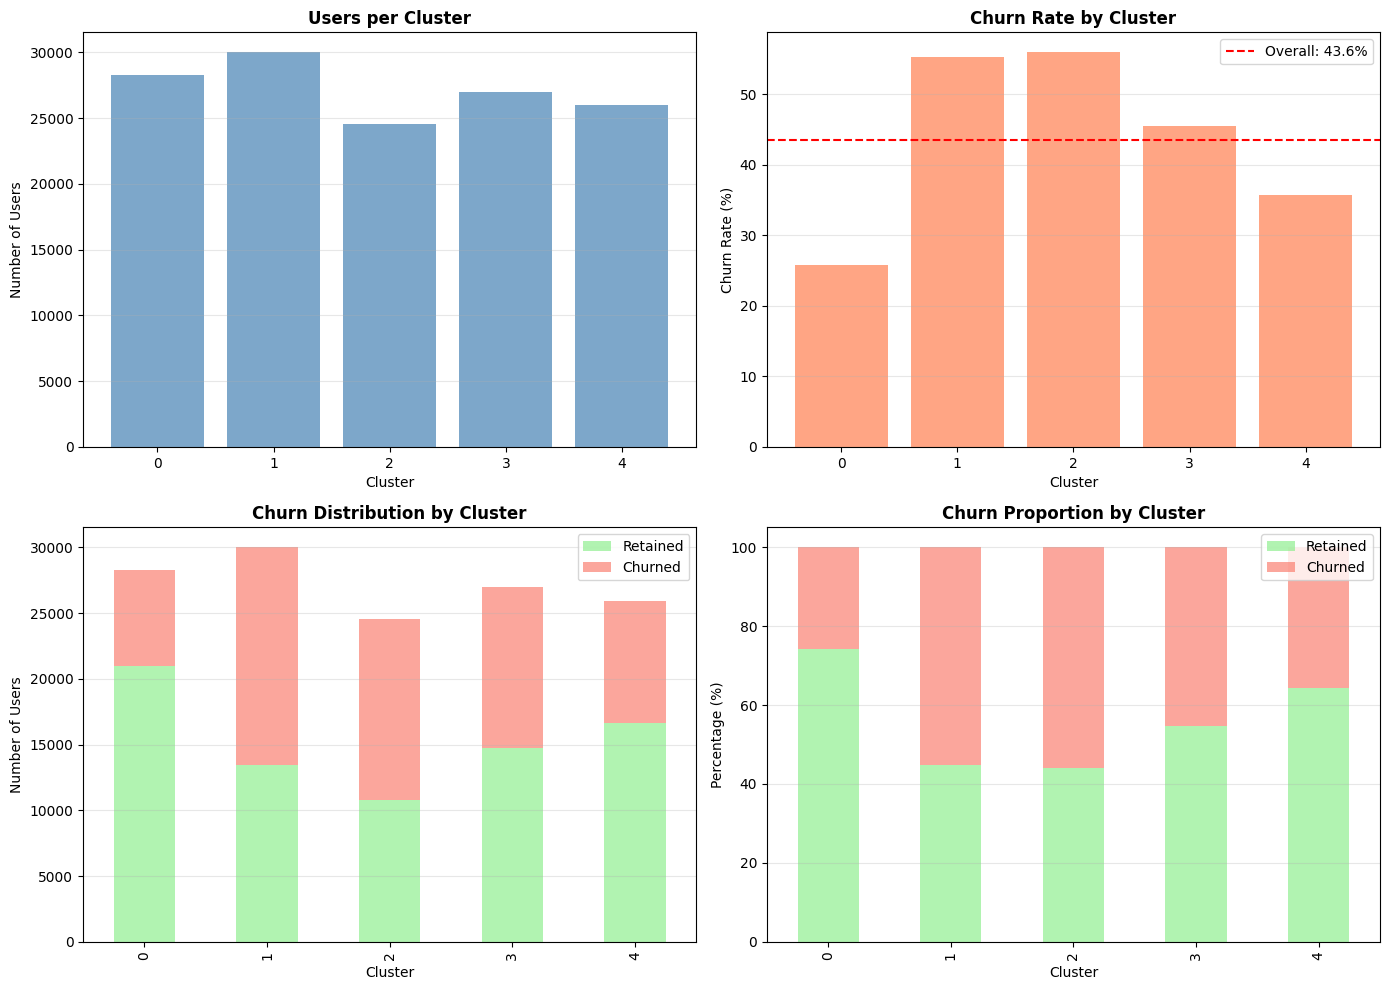


Cluster Profiles:
 cluster  n_users  churn_rate  avg_events  avg_sessions   avg_age  pct_female top_screen     top_feature
       0    28298    0.257757   34.596827      9.997597 42.577179         0.0        Еще Открытие экрана
       1    30025    0.552639    2.982481      1.770558 33.134488         0.0        Еще Открытие экрана
       2    24575    0.559919    2.176928      1.218230 53.033123         0.0        Еще Открытие экрана
       3    27001    0.454391    4.157883      2.458983 51.795008         0.0        Еще Открытие экрана
       4    25961    0.357729   13.302377      4.405647 45.275952         0.0        Еще Открытие экрана


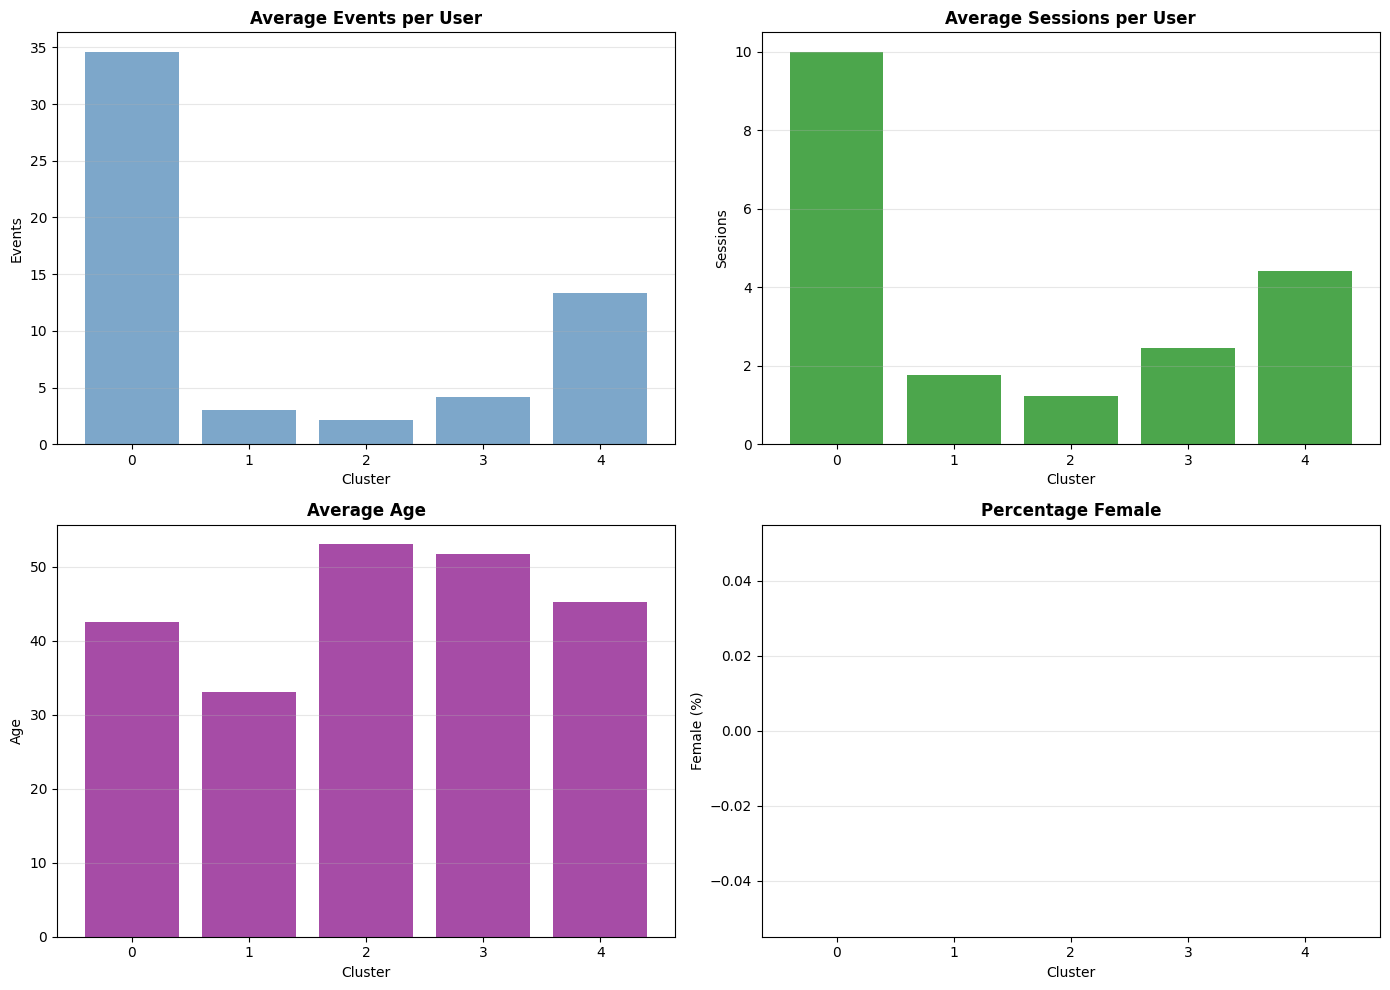


TRAINING GRU ENCODER
Epoch 5/20 | Loss: 0.0352
Epoch 10/20 | Loss: 0.0592
Epoch 15/20 | Loss: 0.0387
Epoch 20/20 | Loss: 0.0524

Extracting embeddings...
Clustering into 5 clusters...

Visualizing...


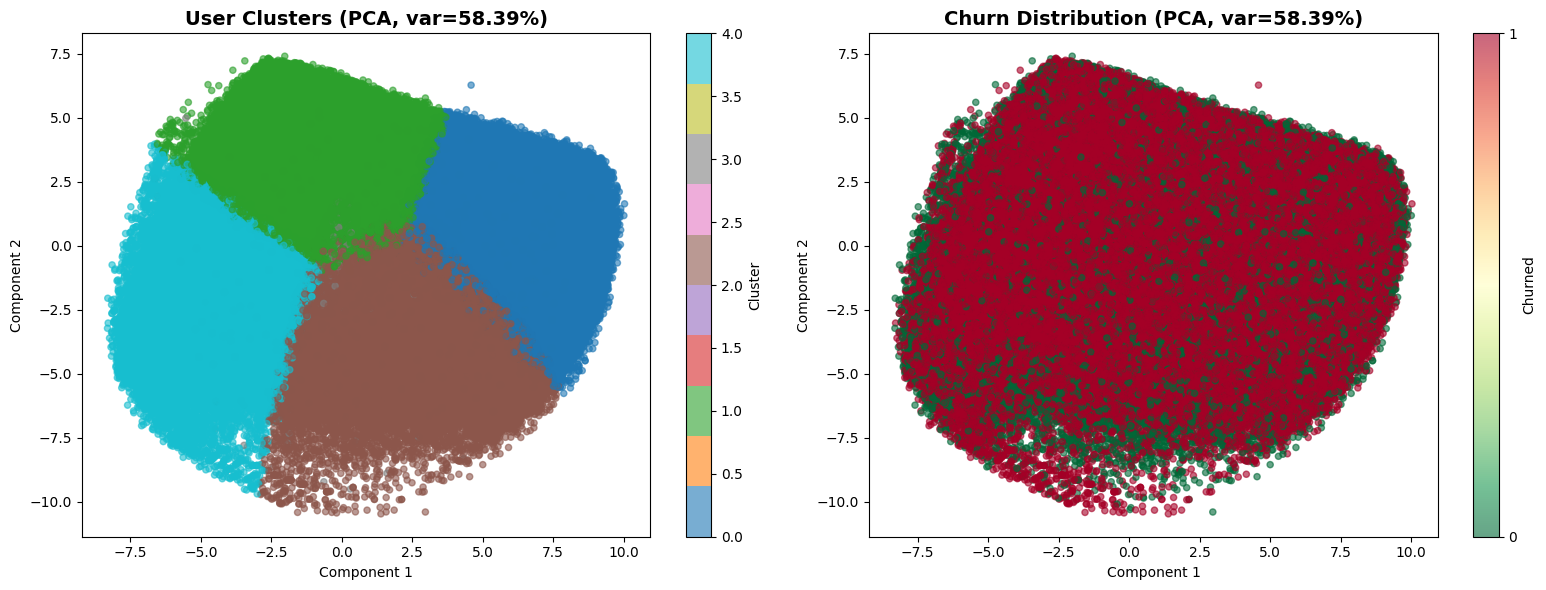

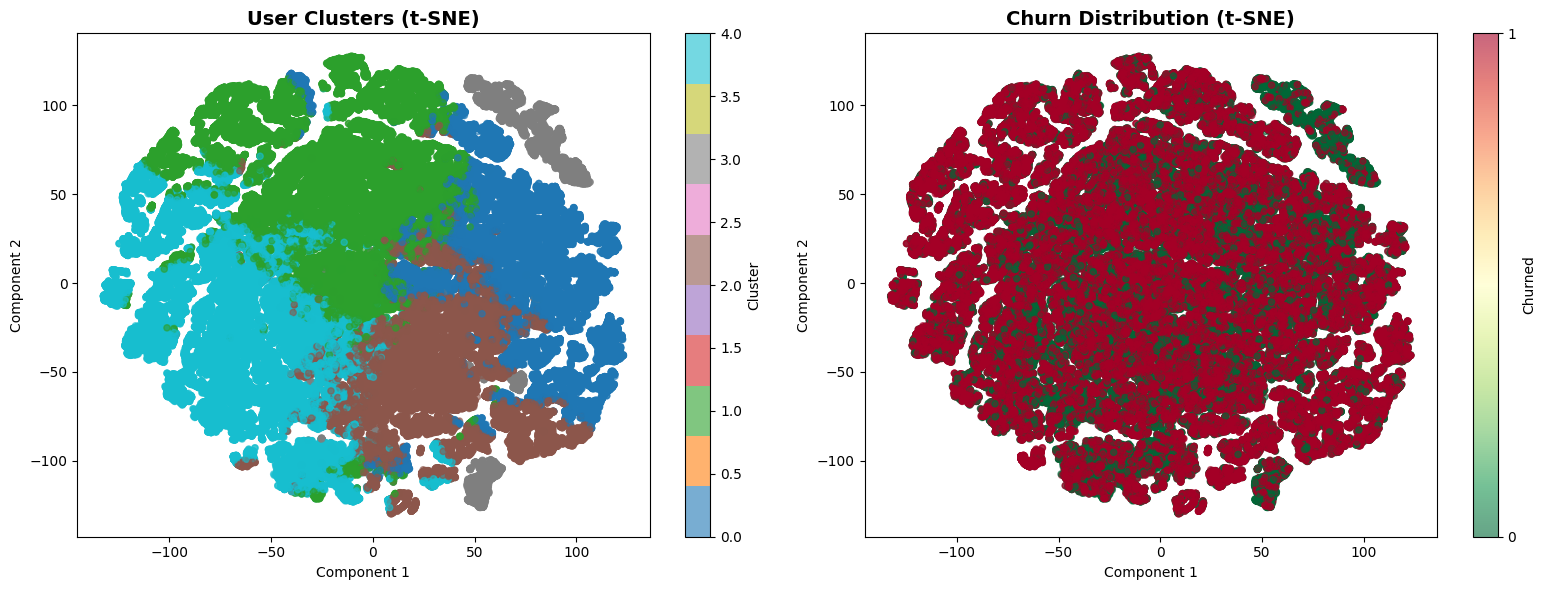

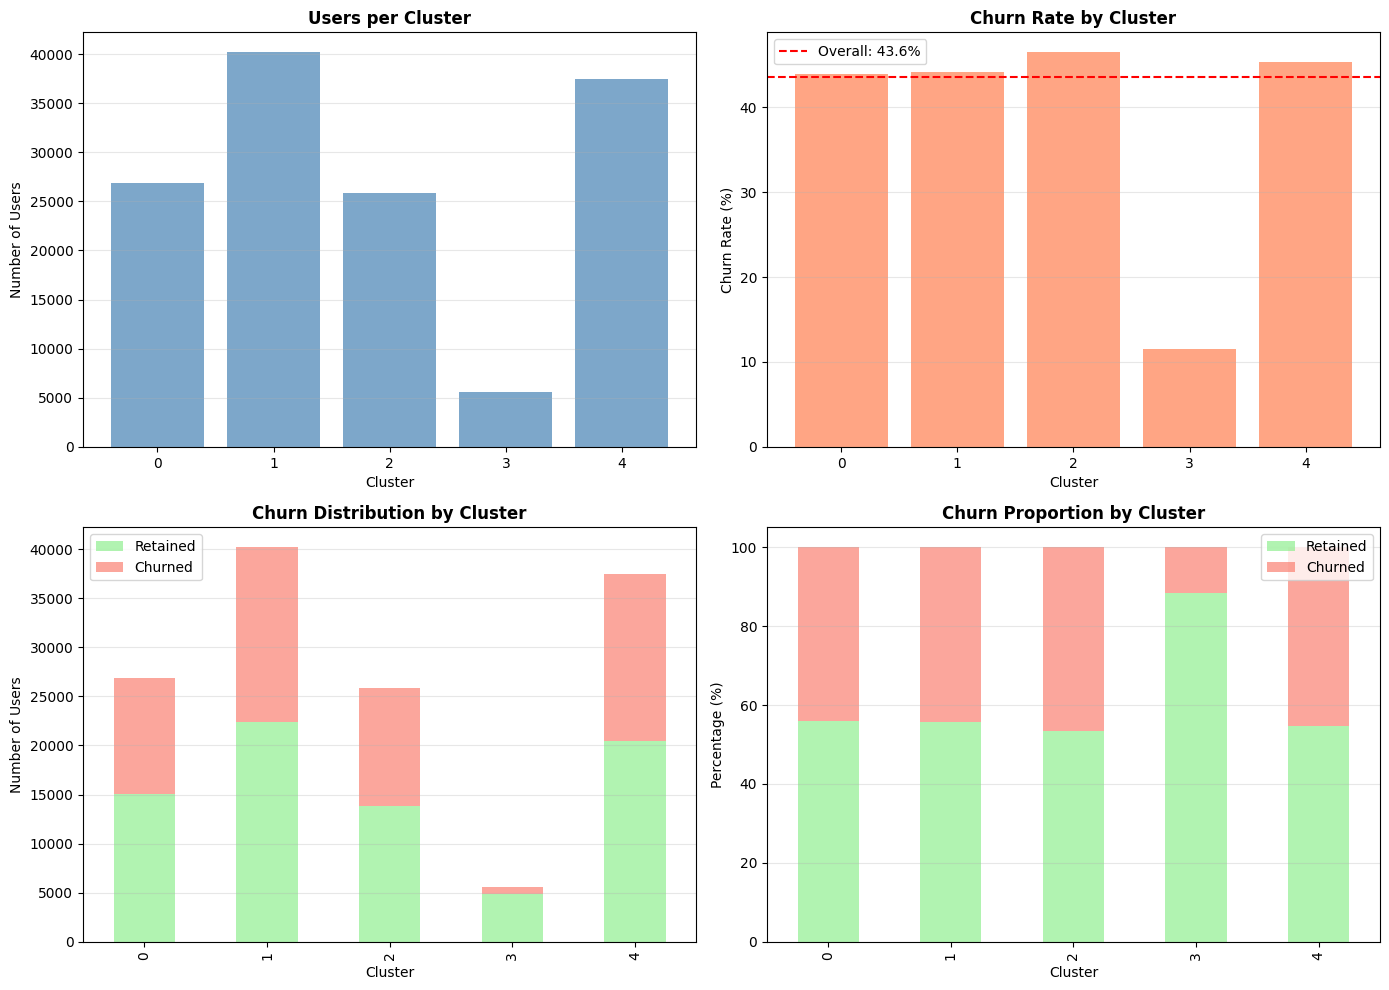


Cluster Profiles:
 cluster  n_users  churn_rate  avg_events  avg_sessions   avg_age  pct_female top_screen     top_feature
       0    26822    0.439341    7.609425      2.891507 54.985273         0.0        Еще Открытие экрана
       1    40201    0.442054    7.760031      2.895177 50.003209         0.0        Еще Открытие экрана
       2    25812    0.465132    7.903223      3.304355 39.536921         0.0        Еще Открытие экрана
       3     5559    0.114949   91.256521     22.935780 45.450621         0.0        Еще Открытие экрана
       4    37466    0.453825    9.403833      3.737896 35.198473         0.0        Еще Открытие экрана


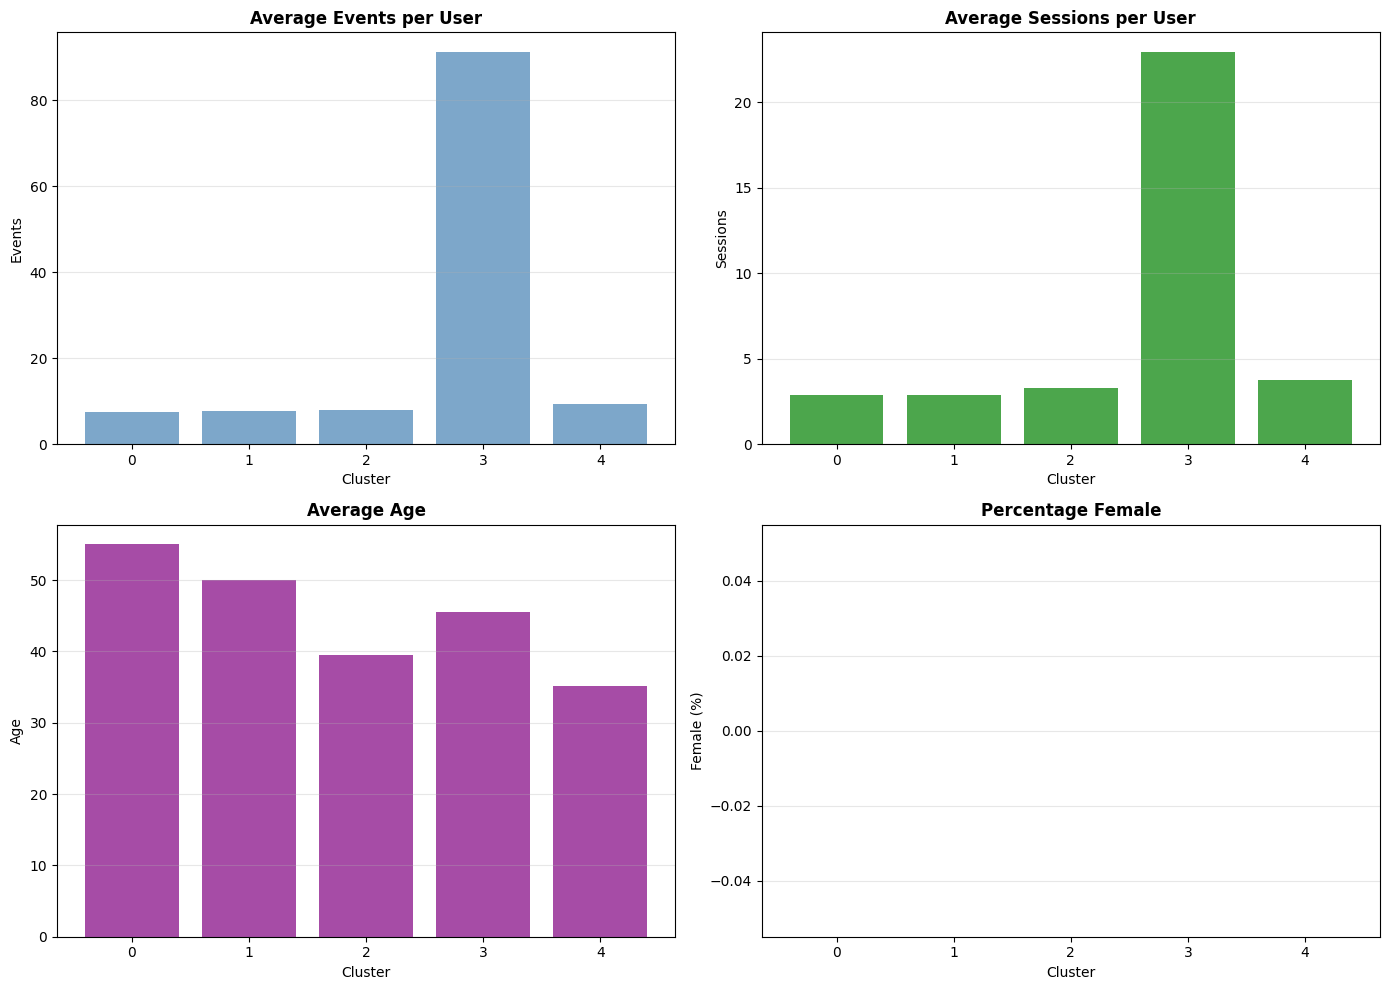


TRAINING TRANSFORMER ENCODER
Epoch 5/20 | Loss: 0.0733
Epoch 10/20 | Loss: 0.0424
Epoch 15/20 | Loss: 0.0365
Epoch 20/20 | Loss: 0.0350

Extracting embeddings...
Clustering into 5 clusters...

Visualizing...


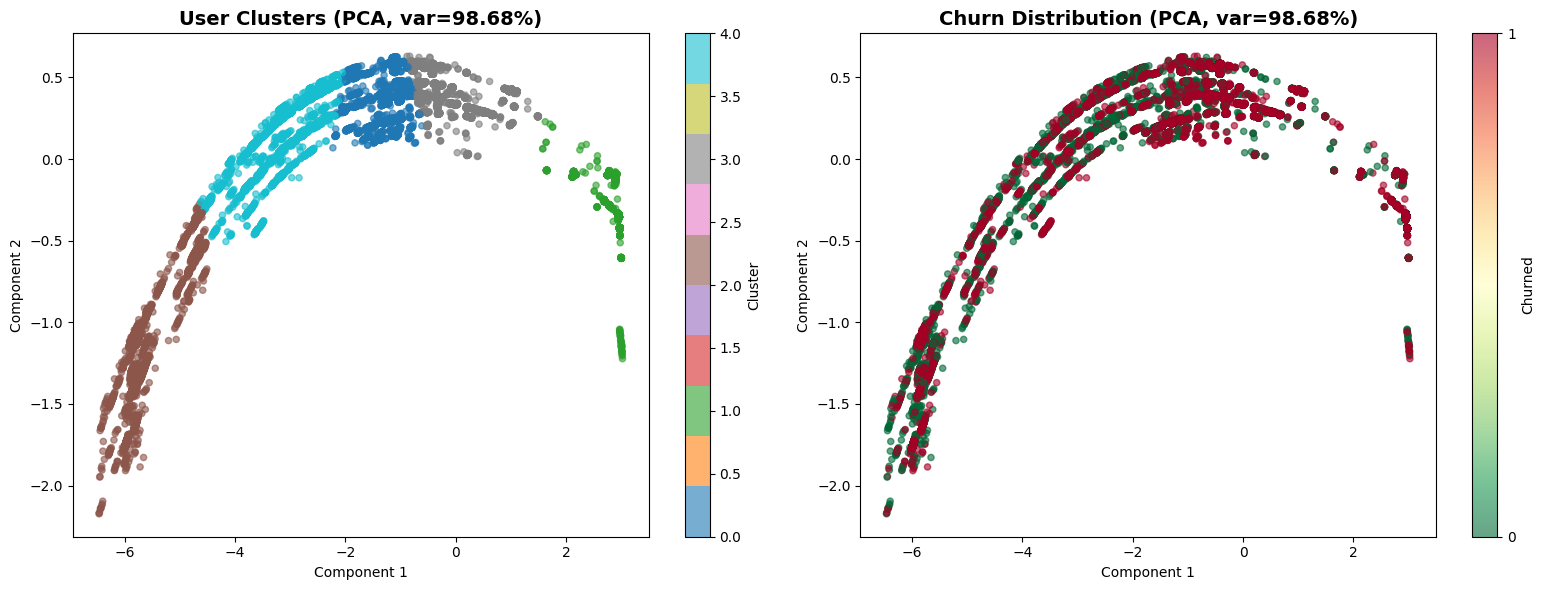

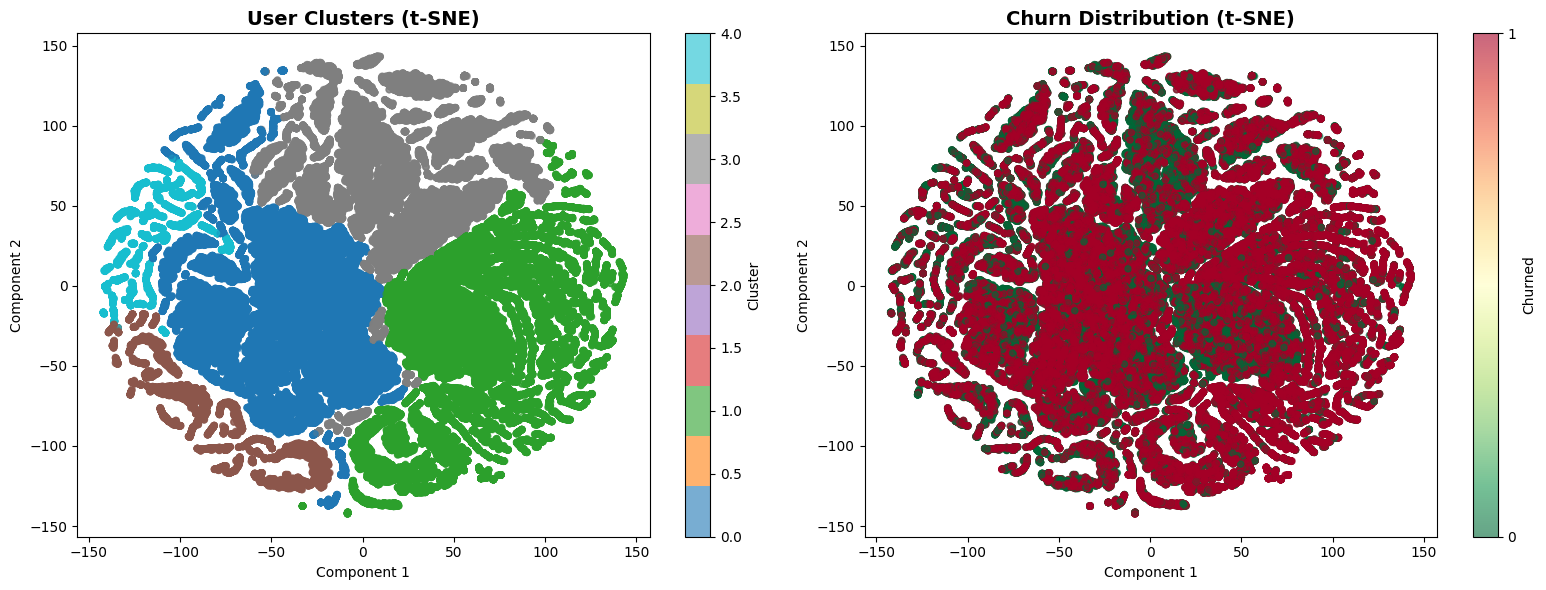

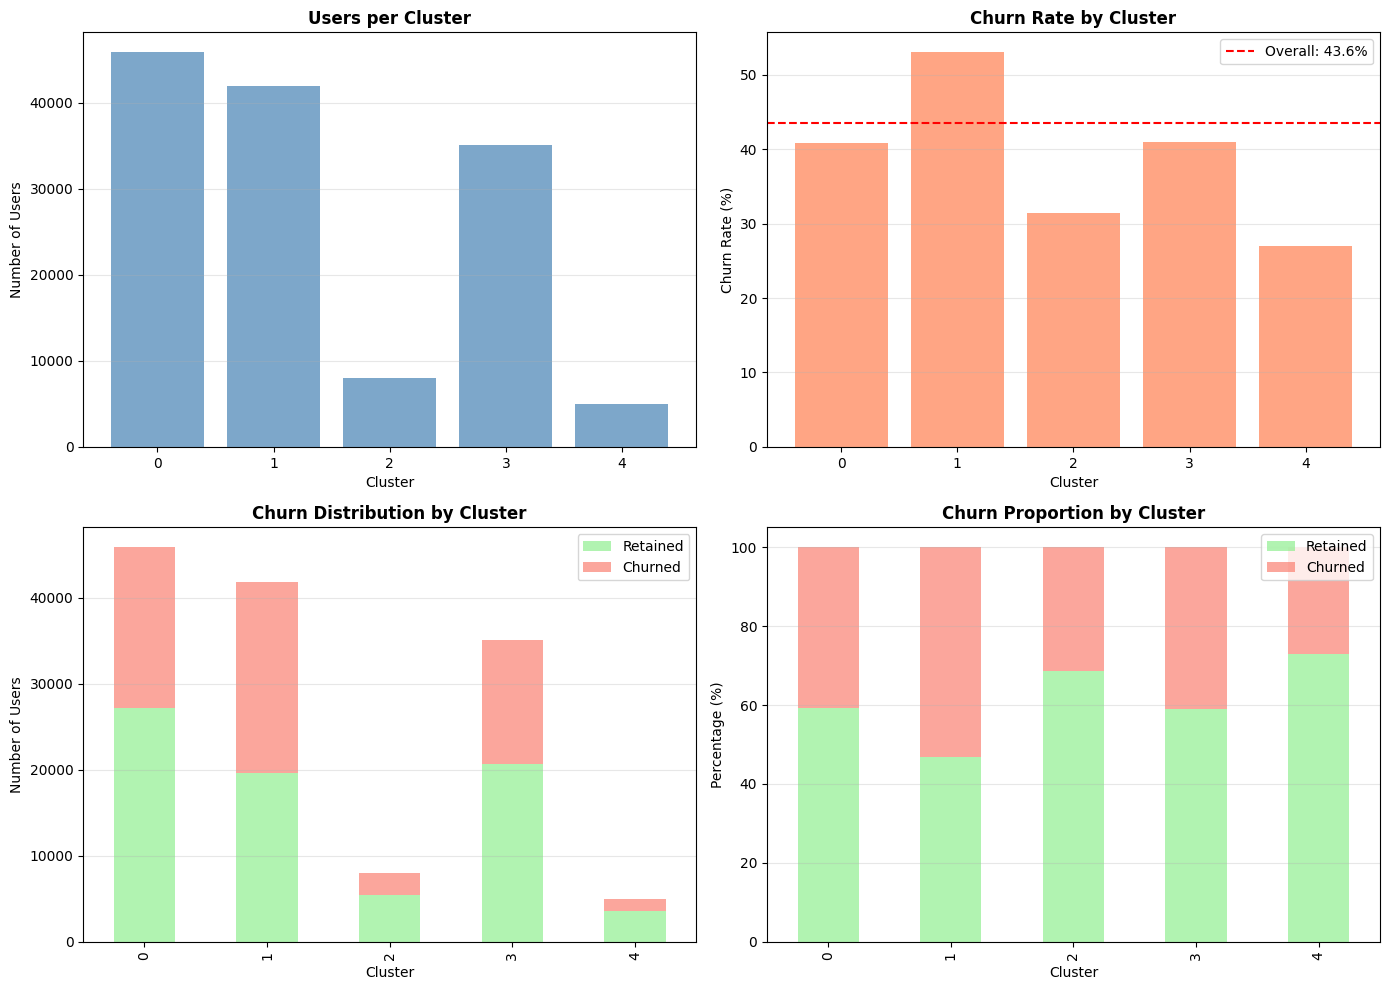


Cluster Profiles:
 cluster  n_users  churn_rate  avg_events  avg_sessions   avg_age  pct_female   top_screen     top_feature
       0    45912    0.408477   14.033499      4.730376 44.955654         0.0          Еще Открытие экрана
       1    41909    0.530674    2.656756      2.447135 44.361951         0.0          Еще Открытие экрана
       2     7987    0.314636   32.042319      5.526105 45.801177         0.0 Новая заявка Открытие экрана
       3    35063    0.409149   11.993241      4.105325 44.941334         0.0          Еще Открытие экрана
       4     4989    0.270595   29.582882      7.809381 42.526759         0.0 Новая заявка Открытие экрана


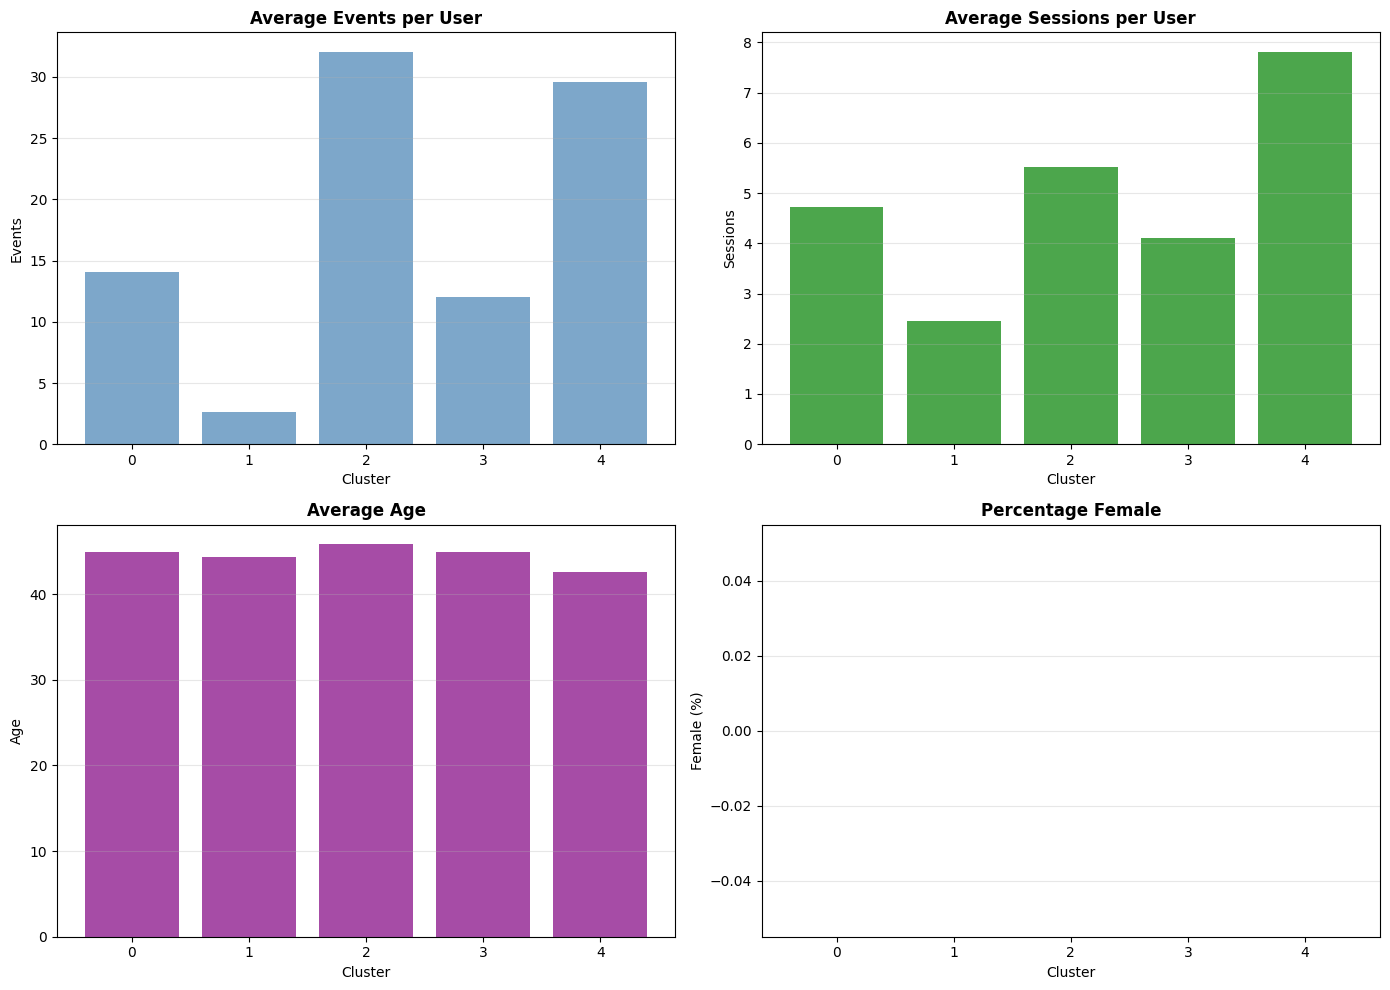

In [14]:
embeddings_lstm, clusters_lstm = train_and_cluster_lstm()

embeddings_gru, clusters_gru = train_and_cluster_gru()

embeddings_transformer, clusters_transformer = train_and_cluster_transformer()


TRAINING ALL MODELS

TRAINING LSTM ENCODER
Epoch 5/20 | Loss: 0.0586
Epoch 10/20 | Loss: 0.0295
Epoch 15/20 | Loss: 0.0315
Epoch 20/20 | Loss: 0.0315

Extracting embeddings...
Clustering into 5 clusters...

Visualizing...


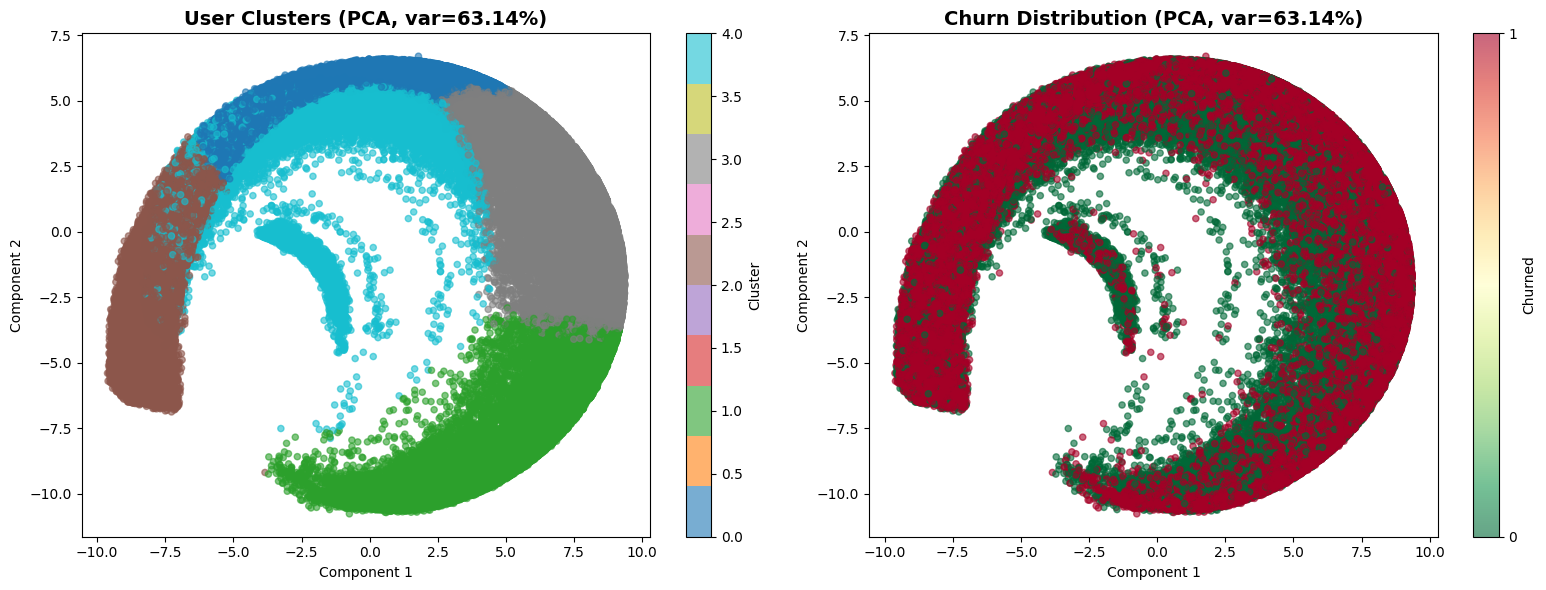

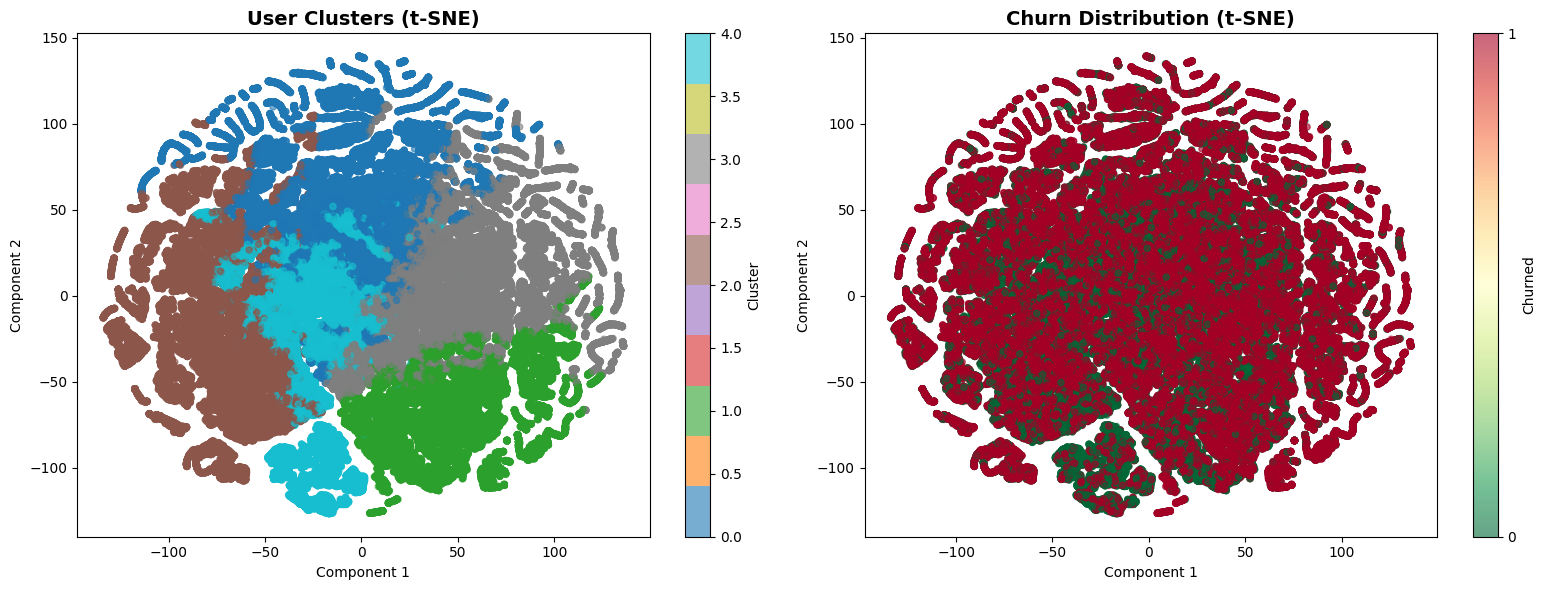

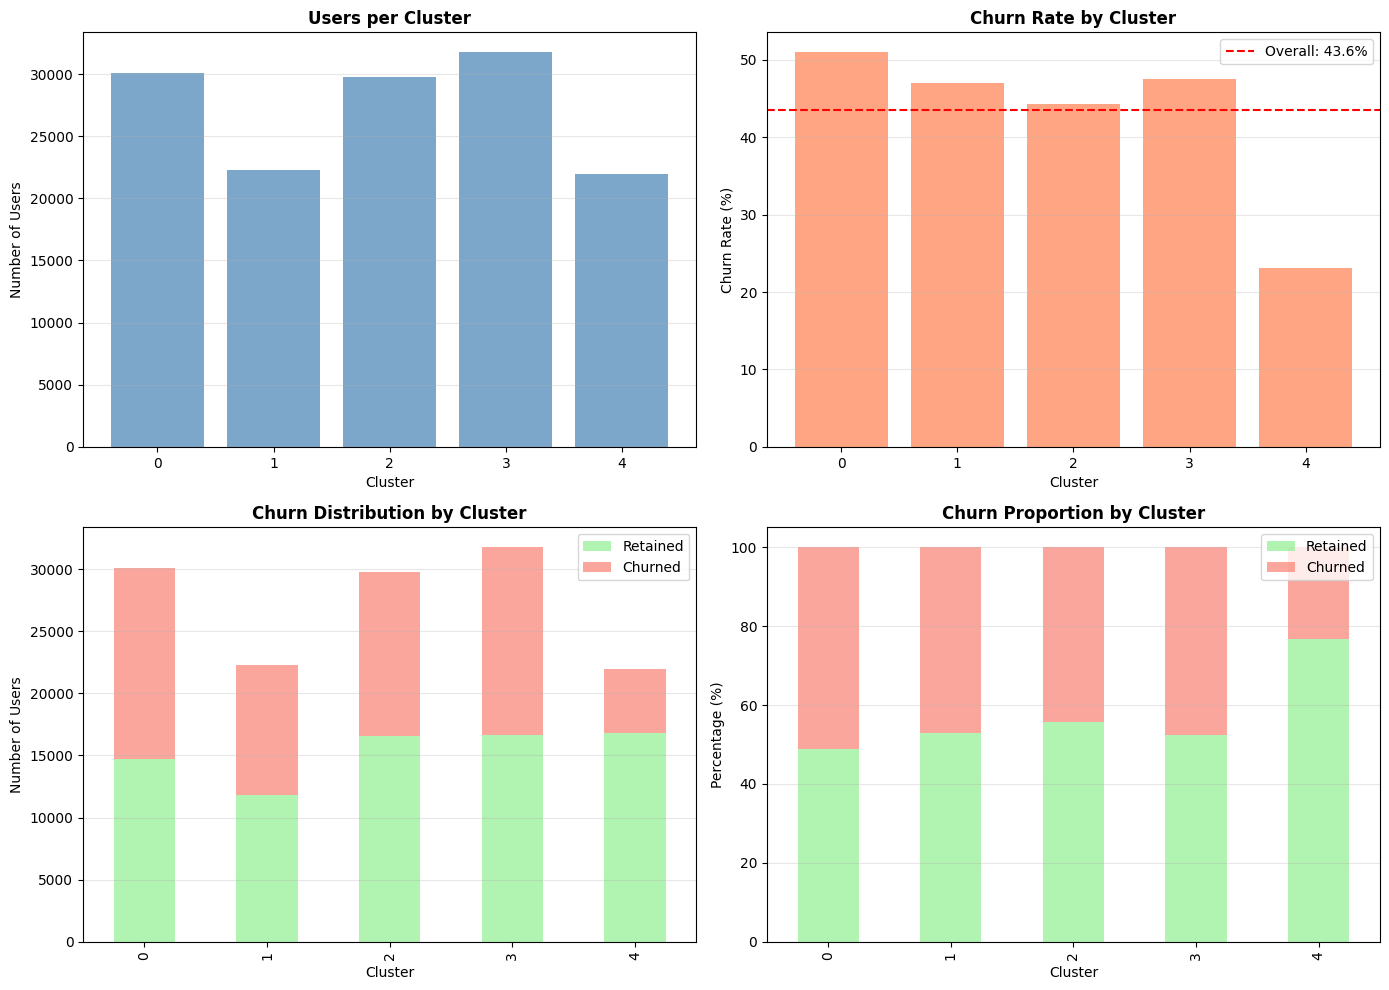


Cluster Profiles:
 cluster  n_users  churn_rate  avg_events  avg_sessions   avg_age  pct_female top_screen     top_feature
       0    30101    0.510182    3.798246      1.993588 45.939470         0.0        Еще Открытие экрана
       1    22298    0.470715    8.746659      3.810387 28.441789         0.0        Еще Открытие экрана
       2    29768    0.442556    6.113142      2.684561 60.794477         0.0        Еще Открытие экрана
       3    31767    0.475273    6.445242      2.712249 37.887651         0.0        Еще Открытие экрана
       4    21926    0.231597   40.298823     10.751345 47.733330         0.0        Еще Открытие экрана


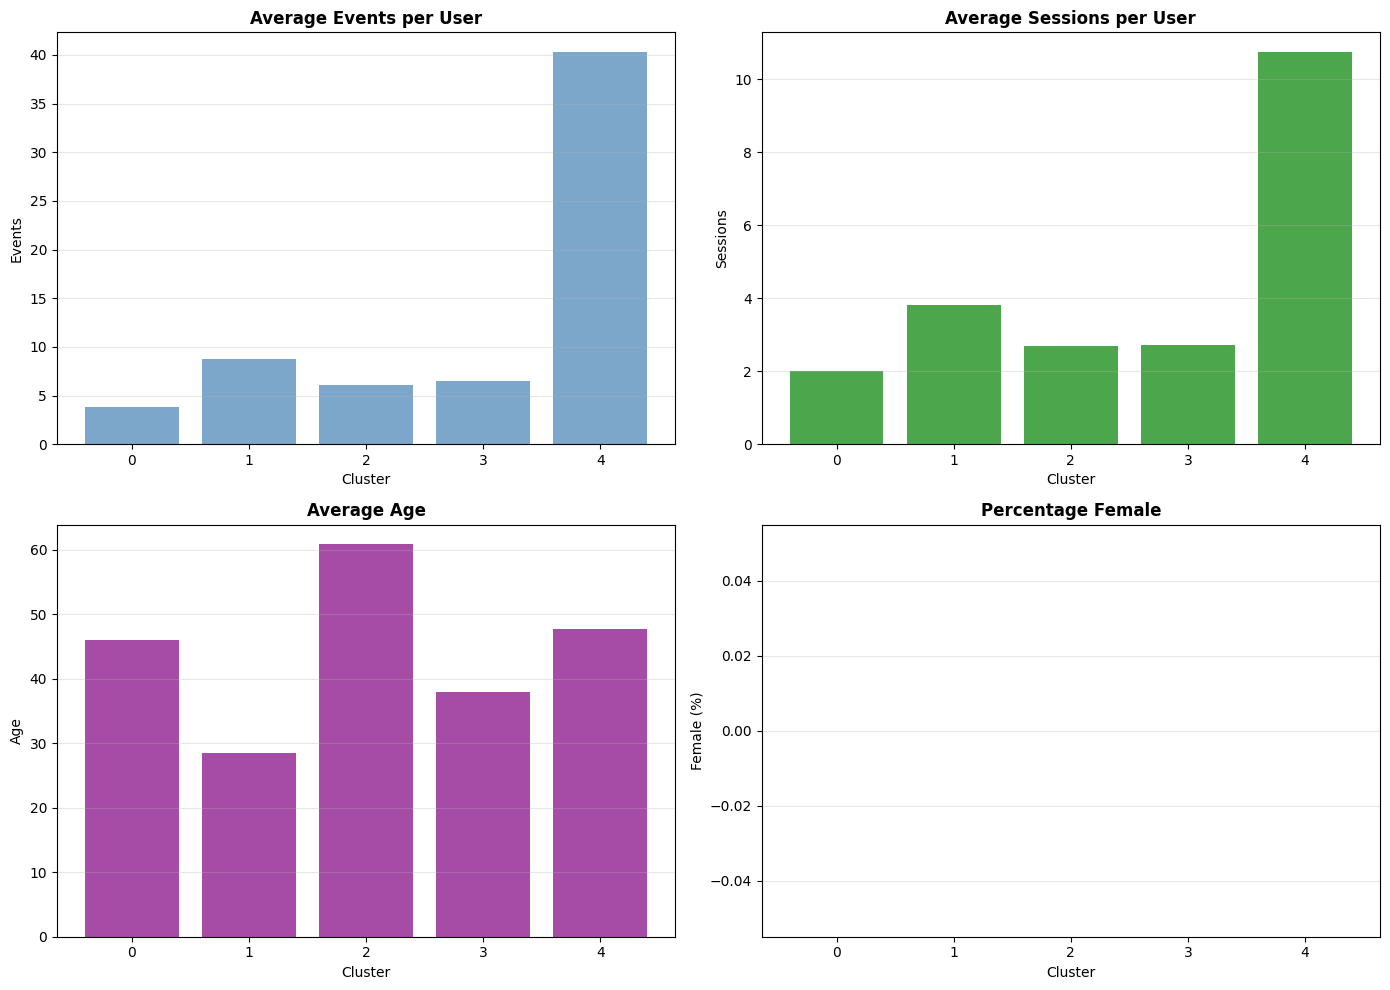


TRAINING GRU ENCODER
Epoch 5/20 | Loss: 0.0802
Epoch 10/20 | Loss: 0.0655
Epoch 15/20 | Loss: 0.0401
Epoch 20/20 | Loss: 0.0320

Extracting embeddings...
Clustering into 5 clusters...

Visualizing...


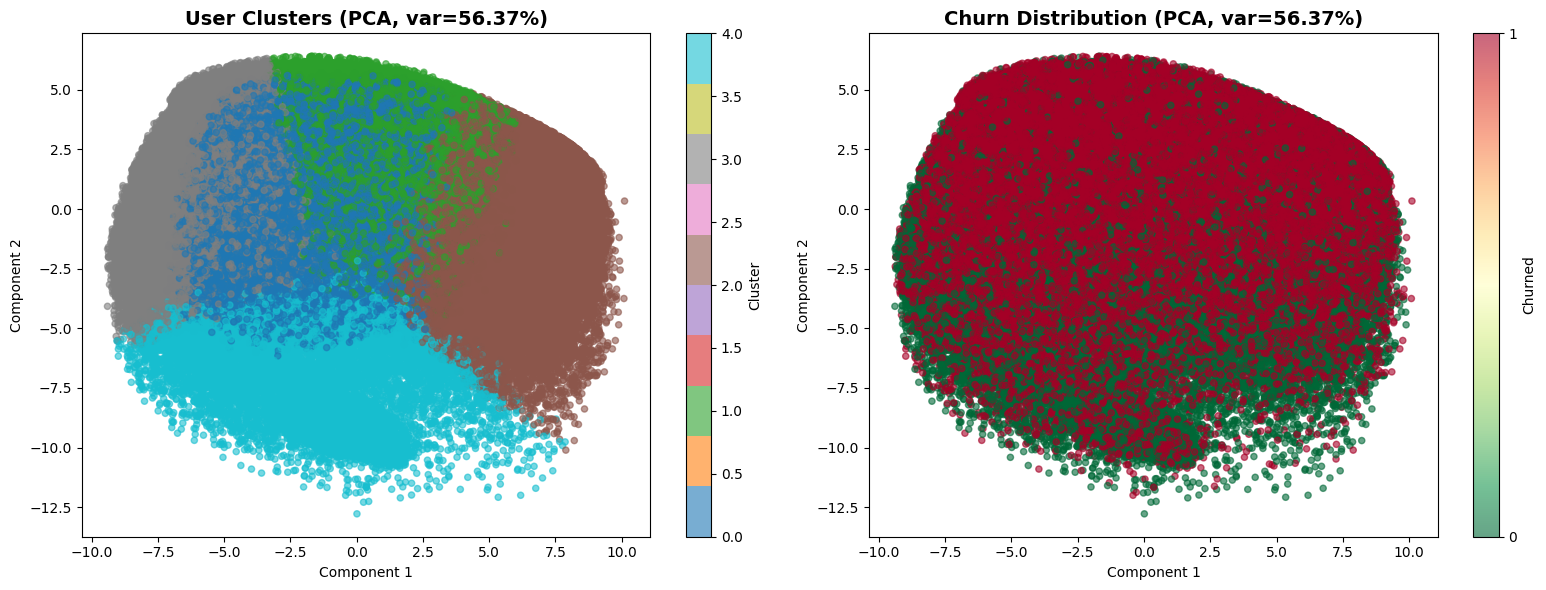

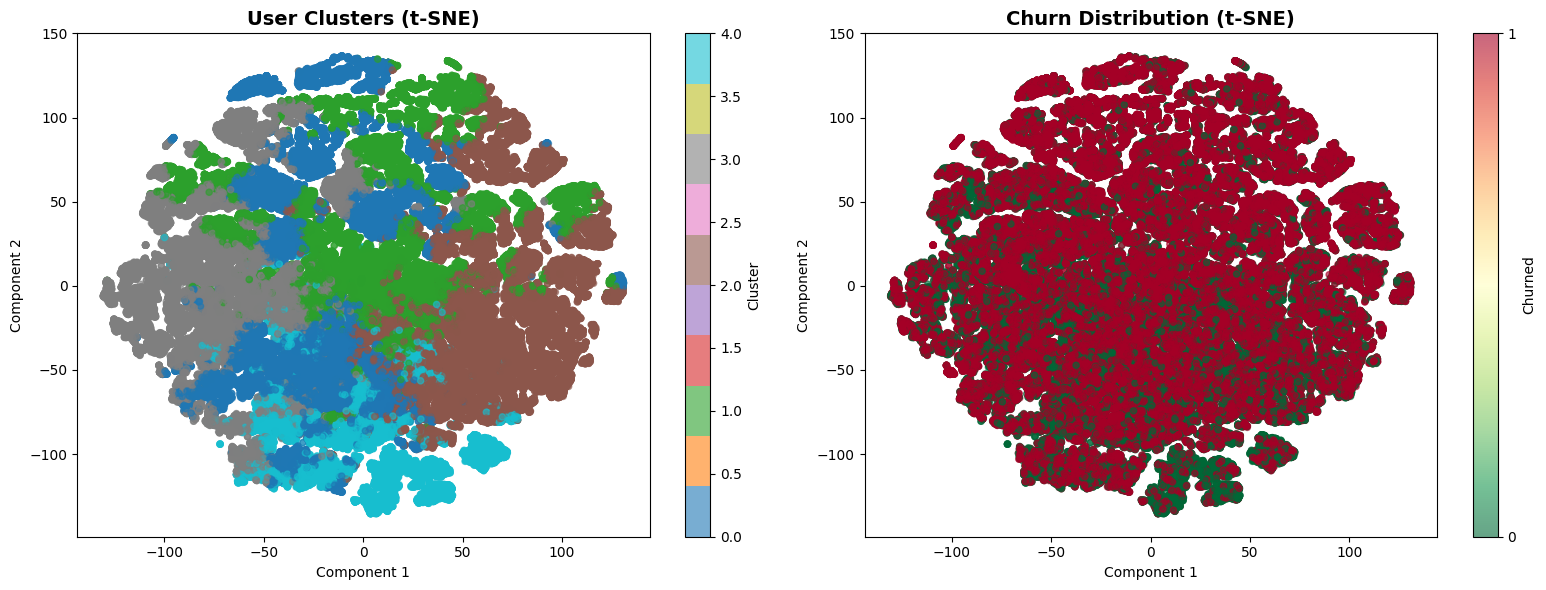

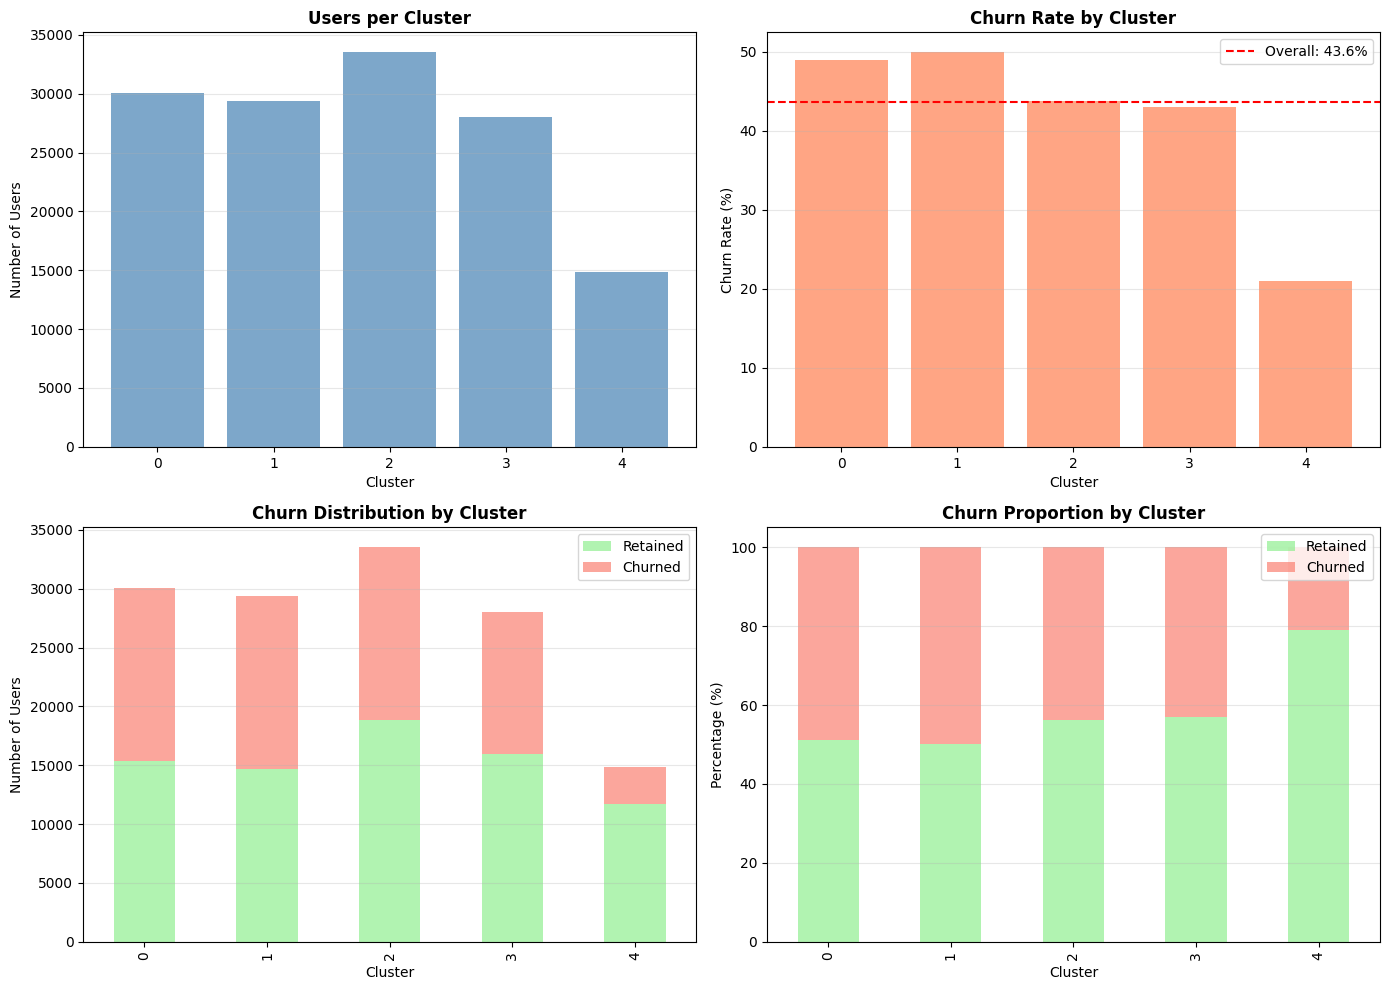


Cluster Profiles:
 cluster  n_users  churn_rate  avg_events  avg_sessions   avg_age  pct_female top_screen     top_feature
       0    30077    0.488845    5.224989      2.351232 38.900190         0.0        Еще Открытие экрана
       1    29384    0.499319    5.781105      2.178056 45.959093         0.0        Еще Открытие экрана
       2    33534    0.437228    6.867716      2.808523 59.175106         0.0        Еще Открытие экрана
       3    28023    0.429897    9.852907      4.376227 33.118403         0.0        Еще Открытие экрана
       4    14842    0.210147   50.279208     13.155033 43.390985         0.0        Еще Открытие экрана


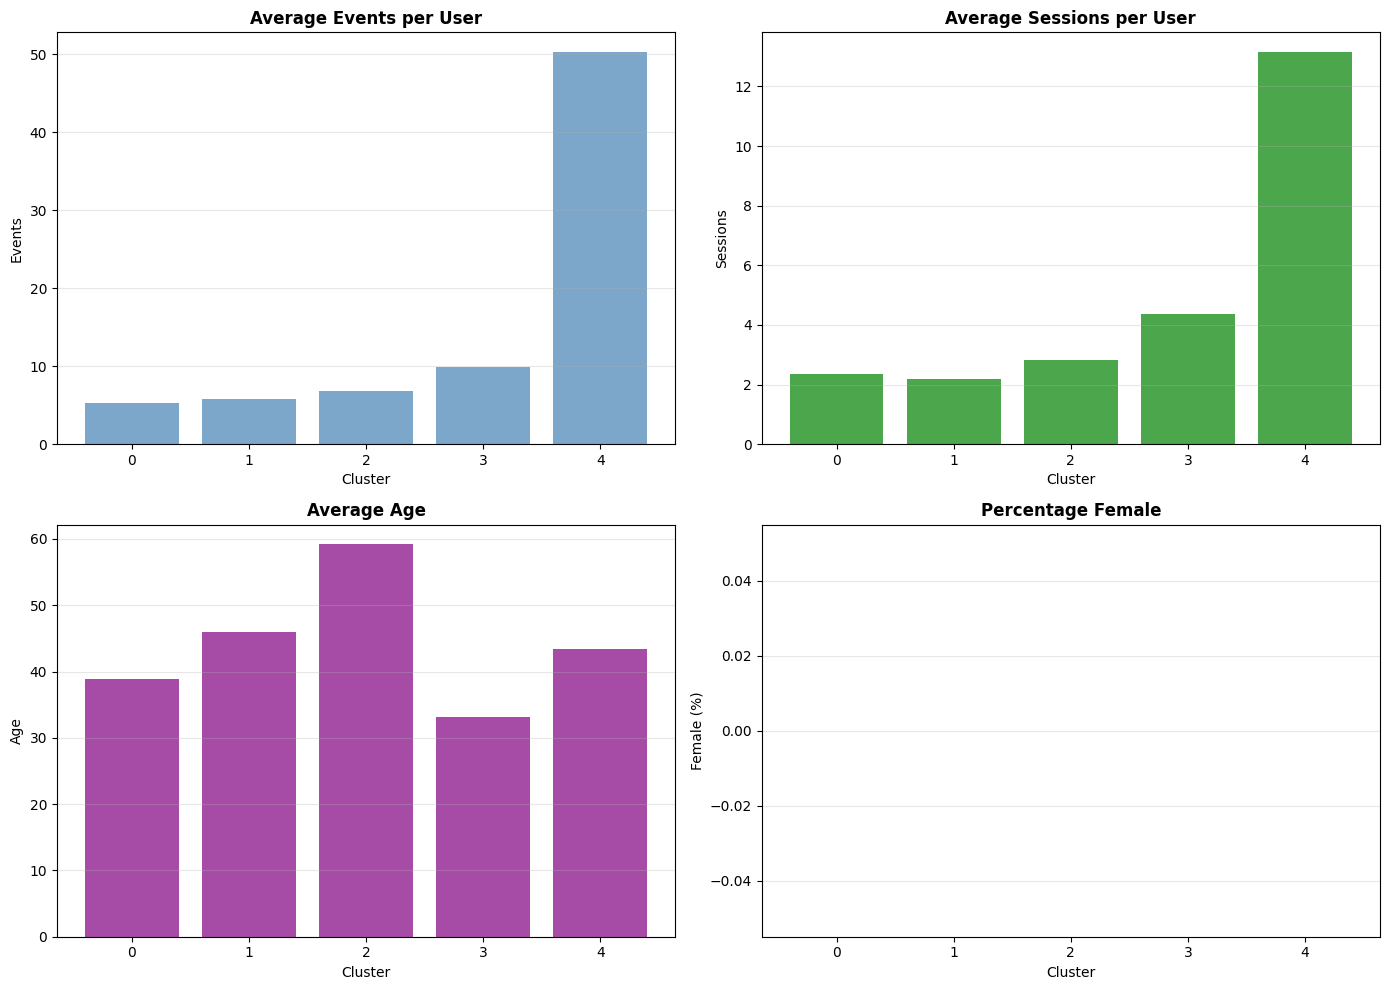


TRAINING TRANSFORMER ENCODER
Epoch 5/20 | Loss: 0.0570
Epoch 10/20 | Loss: 0.0632
Epoch 15/20 | Loss: 0.0366
Epoch 20/20 | Loss: 0.0295

Extracting embeddings...
Clustering into 5 clusters...

Visualizing...


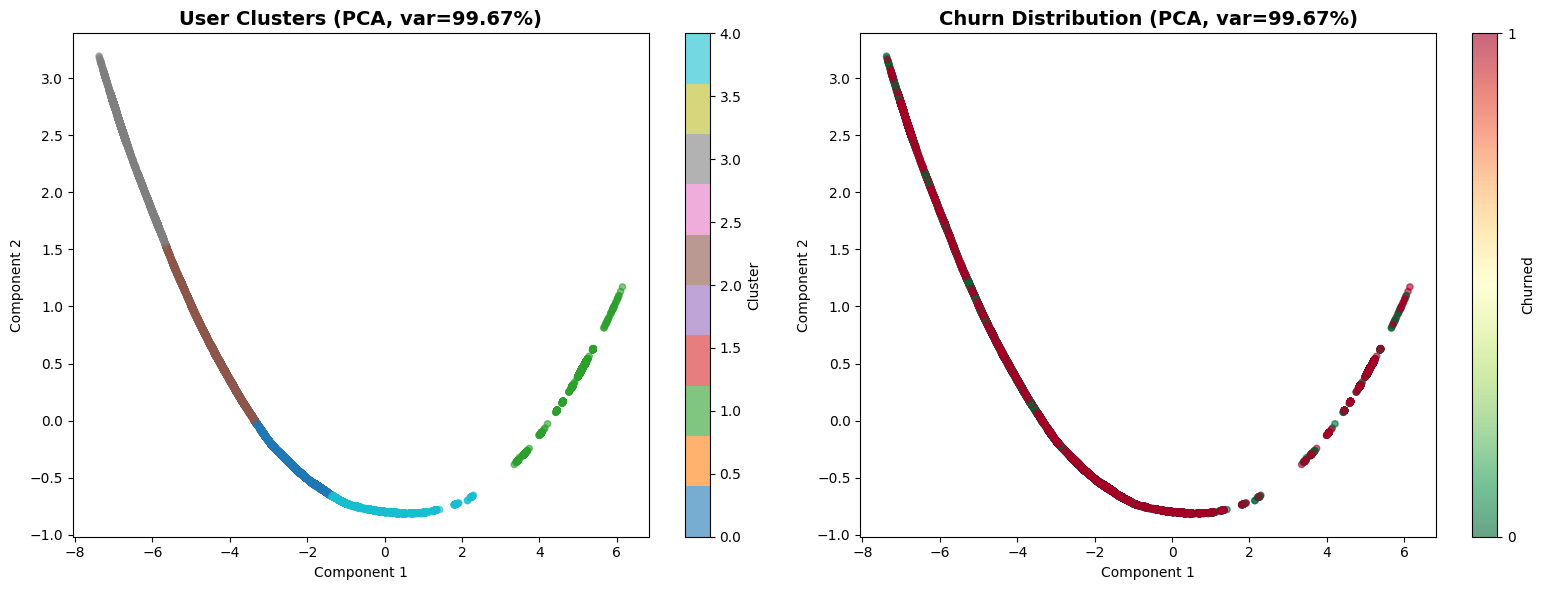

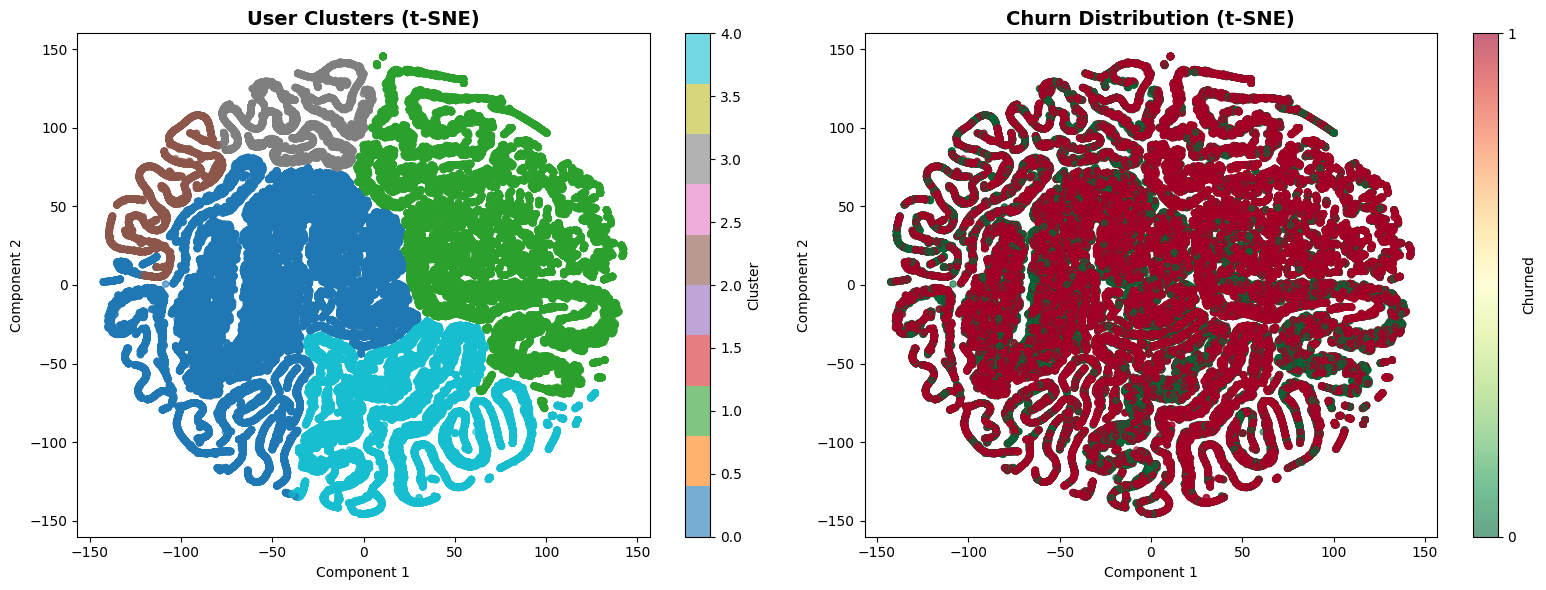

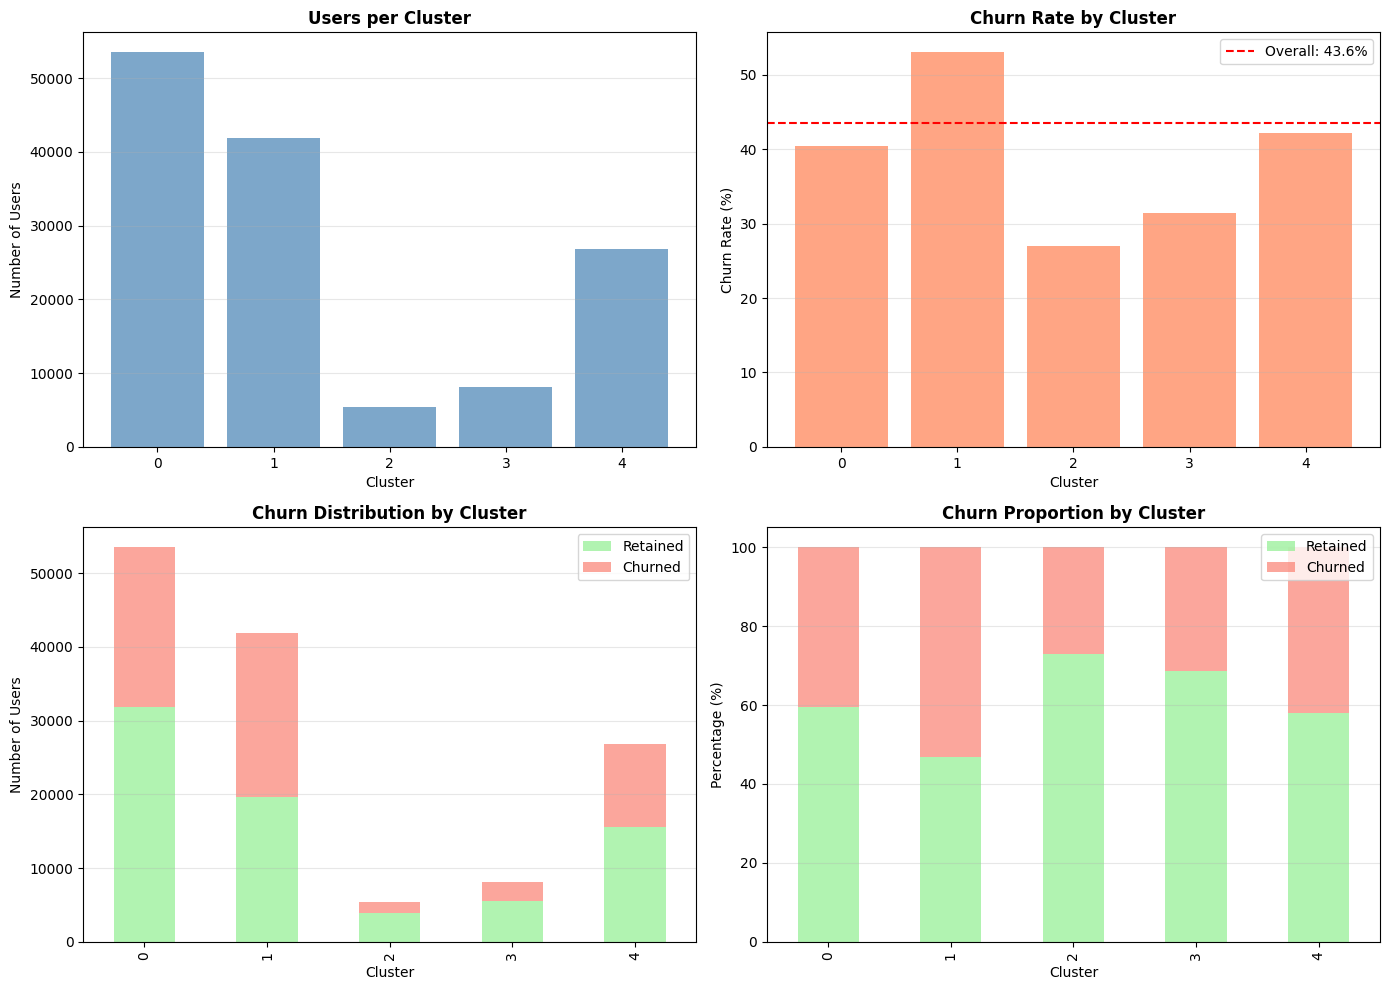


Cluster Profiles:
 cluster  n_users  churn_rate  avg_events  avg_sessions   avg_age  pct_female   top_screen     top_feature
       0    53542    0.403776   15.210863      4.856692 44.976859         0.0          Еще Открытие экрана
       1    41883    0.530740    2.655421      2.447007 44.357973         0.0          Еще Открытие экрана
       2     5395    0.270436   29.325857      7.721038 42.589435         0.0 Новая заявка Открытие экрана
       3     8145    0.314426   32.021363      5.560344 45.642112         0.0 Новая заявка Открытие экрана
       4    26895    0.421454    8.738204      3.618219 44.967689         0.0          Еще Открытие экрана


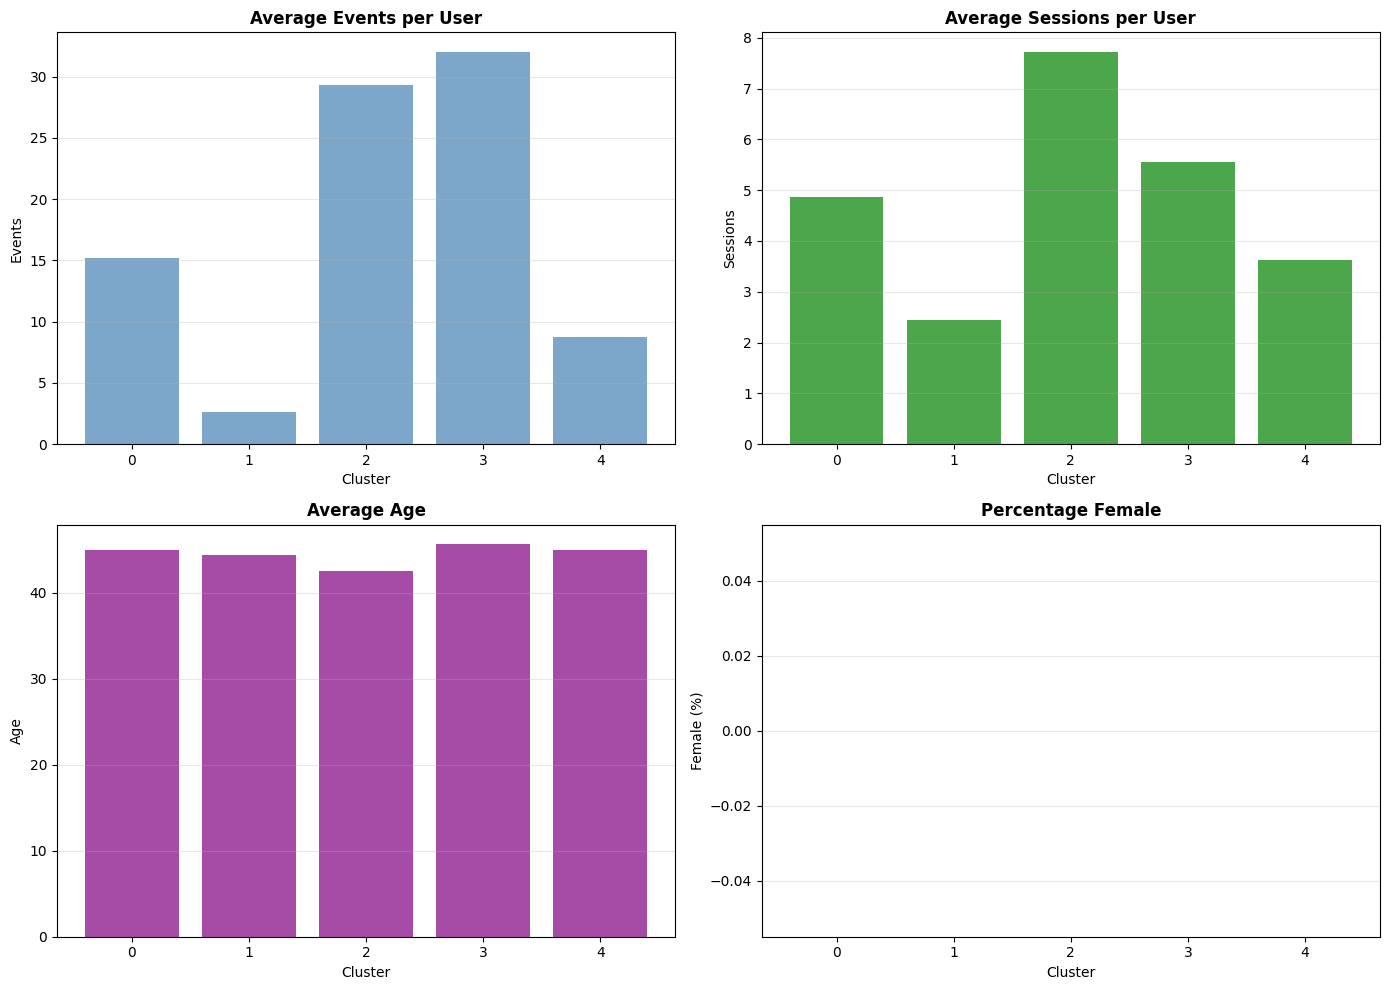


Model Comparison:
      model  n_clusters  min_cluster_size  max_cluster_size  churn_std  churn_range
       LSTM           5             21926             31767   0.111333     0.278585
        GRU           5             14842             33534   0.117500     0.289172
Transformer           5              5395             53542   0.101214     0.260305


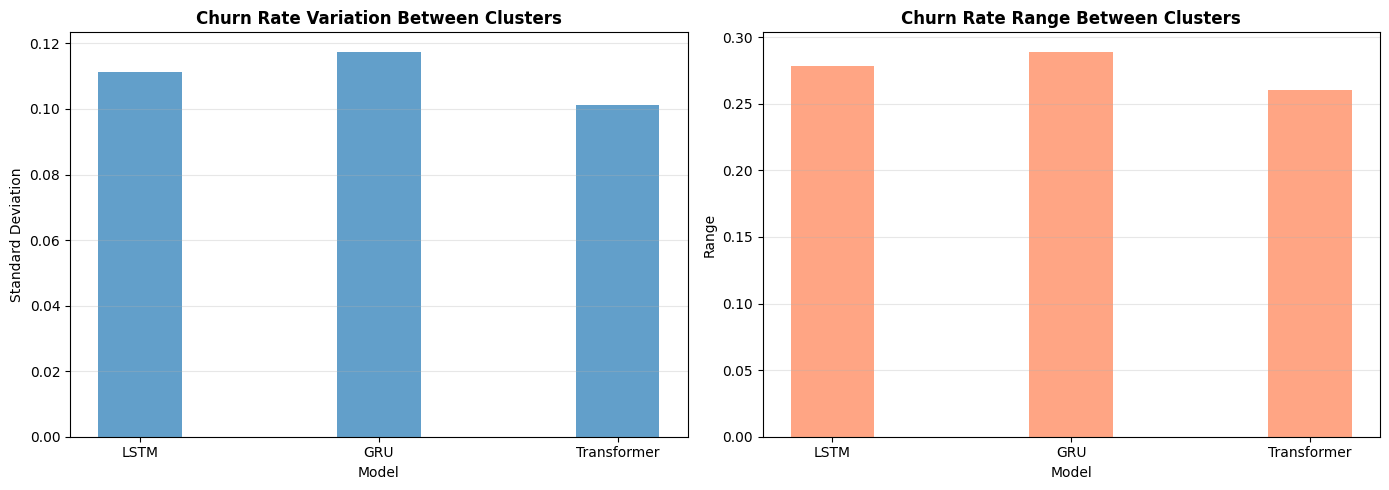

({'LSTM': array([[ 0.48714522, -1.5050852 ,  2.0707653 , ..., -1.1706254 ,
          -2.386971  ,  0.04086989],
         [ 0.18824951,  0.21651793,  0.78402954, ..., -3.3946385 ,
          -0.45921332,  0.10404515],
         [-0.2409885 ,  0.5850927 ,  1.8497381 , ...,  1.4207494 ,
          -1.6564761 , -0.4754885 ],
         ...,
         [-0.00634965, -0.848147  ,  2.5976503 , ..., -2.1884694 ,
          -2.4288683 ,  1.1715889 ],
         [ 0.18744016, -0.9206494 ,  3.2506013 , ..., -1.5358169 ,
          -2.7061062 ,  1.0581061 ],
         [ 0.16841865,  0.45470062,  0.96764886, ..., -0.10625452,
          -1.4999061 ,  0.6511855 ]], dtype=float32),
  'GRU': array([[ 1.198856  , -1.0523474 ,  0.02953036, ...,  1.2472706 ,
          -0.24132913, -3.3194394 ],
         [-0.09492375, -0.80786216, -0.00554951, ...,  0.12337902,
           0.37450713, -2.2023754 ],
         [ 0.40401945, -0.24909945, -0.15155676, ...,  0.46067637,
           0.19171605,  0.8295516 ],
         ...,
    

In [15]:
compare_all_models()

In [20]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

DATA_PATH = "/content/group_project/clean_data.csv"
SAVE_DIR = "/content/group_project/"

def load_best_xgboost():
    model_data = joblib.load(f'{SAVE_DIR}baseline_xgboost_model.pkl')
    model = model_data['model']
    return model

def plot_feature_importance(model, feature_names, save_path=None):
    importances = model.feature_importances_

    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print("\nFeature Importance:")
    print("="*60)
    print(feature_imp.to_string(index=False))
    print("="*60)

    fig, ax = plt.subplots(figsize=(10, 8))

    top_features = feature_imp.head(15)
    colors = plt.cm.RdYlGn_r(top_features['importance'] / top_features['importance'].max())

    bars = ax.barh(range(len(top_features)), top_features['importance'], color=colors)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['feature'])
    ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
    ax.set_title('XGBoost Feature Importance (Top 15)', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)

    for i, (bar, imp) in enumerate(zip(bars, top_features['importance'])):
        ax.text(imp, i, f' {imp:.4f}', va='center', fontsize=9)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    return feature_imp

class SequenceDataset(Dataset):
    def __init__(self, sequences, labels, max_len=50):
        self.sequences = sequences
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        label = self.labels[idx]

        if len(seq) > self.max_len:
            seq = seq[-self.max_len:]
        else:
            pad = np.zeros((self.max_len - len(seq), seq.shape[1]))
            seq = np.vstack([pad, seq])

        mask = torch.ones(self.max_len)
        if len(self.sequences[idx]) < self.max_len:
            mask[:self.max_len - len(self.sequences[idx])] = 0

        return torch.FloatTensor(seq), torch.FloatTensor([label]), mask

class AttentionLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, dropout=0.3):
        super(AttentionLSTM, self).__init__()

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )

    def forward(self, x, mask):
        lstm_out, _ = self.lstm(x)
        attn_weights = self.attention(lstm_out)
        attn_weights = attn_weights.masked_fill(mask.unsqueeze(-1) == 0, -1e9)
        attn_weights = F.softmax(attn_weights, dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        output = self.classifier(context)
        return torch.sigmoid(output), attn_weights

def load_lstm_model():
    checkpoint = torch.load(f'{SAVE_DIR}lstm_model.pth', map_location='cpu')
    config = checkpoint['config']

    model = AttentionLSTM(**config)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    return model, config

def extract_all_attention(model, dataloader, device='cpu'):
    model = model.to(device)
    model.eval()

    all_attention = []
    all_predictions = []
    all_labels = []
    all_masks = []

    with torch.no_grad():
        for sequences, labels, masks in dataloader:
            sequences, masks = sequences.to(device), masks.to(device)
            predictions, attention = model(sequences, masks)

            all_attention.append(attention.cpu().numpy())
            all_predictions.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_masks.append(masks.cpu().numpy())

    all_attention = np.vstack(all_attention)
    all_predictions = np.vstack(all_predictions)
    all_labels = np.vstack(all_labels)
    all_masks = np.vstack(all_masks)

    return all_attention, all_predictions, all_labels, all_masks

def plot_average_attention_by_position(attention, masks, labels, save_path=None):
    max_len = attention.shape[1]

    churned_idx = (labels.flatten() == 1)
    retained_idx = (labels.flatten() == 0)

    churned_attention = attention[churned_idx].squeeze()
    retained_attention = attention[retained_idx].squeeze()
    churned_masks = masks[churned_idx]
    retained_masks = masks[retained_idx]

    avg_attention_churned = np.zeros(max_len)
    avg_attention_retained = np.zeros(max_len)

    for i in range(max_len):
        mask_churned = churned_masks[:, i] == 1
        mask_retained = retained_masks[:, i] == 1

        if mask_churned.sum() > 0:
            avg_attention_churned[i] = churned_attention[mask_churned, i].mean()

        if mask_retained.sum() > 0:
            avg_attention_retained[i] = retained_attention[mask_retained, i].mean()

    fig, axes = plt.subplots(2, 1, figsize=(14, 8))

    positions = np.arange(max_len)

    axes[0].plot(positions, avg_attention_churned, 'o-', color='red', alpha=0.7, linewidth=2, markersize=4, label='Churned')
    axes[0].plot(positions, avg_attention_retained, 'o-', color='green', alpha=0.7, linewidth=2, markersize=4, label='Retained')
    axes[0].set_xlabel('Sequence Position (0=oldest, 49=newest event)', fontsize=11)
    axes[0].set_ylabel('Average Attention Weight', fontsize=11)
    axes[0].set_title('Average Attention by Sequence Position', fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    diff = avg_attention_churned - avg_attention_retained
    colors = ['red' if d > 0 else 'green' for d in diff]
    axes[1].bar(positions, np.abs(diff), color=colors, alpha=0.6)
    axes[1].set_xlabel('Sequence Position', fontsize=11)
    axes[1].set_ylabel('|Attention Difference|', fontsize=11)
    axes[1].set_title('Attention Difference: Churned vs Retained (red=churned higher, green=retained higher)',
                      fontsize=13, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

def plot_attention_heatmap(attention, masks, labels, n_samples=1000, save_path=None):
    churned_idx = np.where(labels.flatten() == 1)[0]
    retained_idx = np.where(labels.flatten() == 0)[0]

    n_churned = min(n_samples // 2, len(churned_idx))
    n_retained = min(n_samples // 2, len(retained_idx))

    sampled_churned = np.random.choice(churned_idx, n_churned, replace=False)
    sampled_retained = np.random.choice(retained_idx, n_retained, replace=False)

    selected_idx = np.concatenate([sampled_churned, sampled_retained])
    np.random.shuffle(selected_idx)

    attention_matrix = attention[selected_idx].squeeze()
    mask_matrix = masks[selected_idx]
    label_vector = labels[selected_idx].flatten()

    attention_matrix = attention_matrix * mask_matrix

    sort_idx = np.argsort(label_vector)
    attention_sorted = attention_matrix[sort_idx]
    labels_sorted = label_vector[sort_idx]

    fig, ax = plt.subplots(figsize=(14, 10))

    im = ax.imshow(attention_sorted, aspect='auto', cmap='YlOrRd', interpolation='nearest')

    ax.set_xlabel('Sequence Position (0=oldest, 49=newest)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Users (green=retained, red=churned)', fontsize=12, fontweight='bold')
    ax.set_title(f'Attention Heatmap: {len(selected_idx)} Users', fontsize=14, fontweight='bold')

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Attention Weight', fontsize=11)

    churn_boundary = np.where(labels_sorted == 1)[0][0]
    ax.axhline(y=churn_boundary, color='blue', linestyle='--', linewidth=2, label=f'Churn boundary')
    ax.legend(loc='upper right')

    ax.text(-5, churn_boundary / 2, 'RETAINED', rotation=90, va='center', fontsize=12,
            fontweight='bold', color='green')
    ax.text(-5, churn_boundary + (len(selected_idx) - churn_boundary) / 2, 'CHURNED',
            rotation=90, va='center', fontsize=12, fontweight='bold', color='red')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

def plot_attention_distribution(attention, masks, labels, save_path=None):
    attention_flat = attention.squeeze()
    masks_flat = masks
    labels_flat = labels.flatten()

    churned_attention = attention_flat[labels_flat == 1][masks_flat[labels_flat == 1] == 1]
    retained_attention = attention_flat[labels_flat == 0][masks_flat[labels_flat == 0] == 1]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].hist(churned_attention, bins=50, alpha=0.7, color='red', label='Churned', density=True)
    axes[0].hist(retained_attention, bins=50, alpha=0.7, color='green', label='Retained', density=True)
    axes[0].set_xlabel('Attention Weight', fontsize=11)
    axes[0].set_ylabel('Density', fontsize=11)
    axes[0].set_title('Attention Weight Distribution', fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    box_data = [retained_attention, churned_attention]
    bp = axes[1].boxplot(box_data, labels=['Retained', 'Churned'], patch_artist=True)
    bp['boxes'][0].set_facecolor('green')
    bp['boxes'][1].set_facecolor('red')
    axes[1].set_ylabel('Attention Weight', fontsize=11)
    axes[1].set_title('Attention Weight by Churn Status', fontsize=13, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    print(f"\nAttention Statistics:")
    print(f"Churned - Mean: {churned_attention.mean():.6f}, Std: {churned_attention.std():.6f}")
    print(f"Retained - Mean: {retained_attention.mean():.6f}, Std: {retained_attention.std():.6f}")

def plot_recency_effect(attention, masks, save_path=None):
    max_len = attention.shape[1]

    avg_attention = np.zeros(max_len)
    counts = np.zeros(max_len)

    for i in range(len(attention)):
        mask = masks[i] == 1
        attn = attention[i].squeeze()
        avg_attention[mask] += attn[mask]
        counts[mask] += 1

    avg_attention = avg_attention / np.maximum(counts, 1)

    fig, ax = plt.subplots(figsize=(12, 6))

    positions = np.arange(max_len)
    colors = plt.cm.YlOrRd(avg_attention / avg_attention.max())

    bars = ax.bar(positions, avg_attention, color=colors)
    ax.set_xlabel('Sequence Position (0=oldest, 49=newest event)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Average Attention Weight', fontsize=12, fontweight='bold')
    ax.set_title('Recency Effect: Recent Events Get More Attention', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    recent_10 = avg_attention[-10:].mean()
    old_10 = avg_attention[:10].mean()

    ax.axhline(y=recent_10, color='red', linestyle='--', linewidth=2,
               label=f'Last 10 events avg: {recent_10:.6f}')
    ax.axhline(y=old_10, color='blue', linestyle='--', linewidth=2,
               label=f'First 10 events avg: {old_10:.6f}')
    ax.legend()

    ax.text(45, recent_10 * 1.1, f'{recent_10/old_10:.1f}x more attention',
            fontsize=11, fontweight='bold', color='red')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    print(f"\nRecency Effect:")
    print(f"Last 10 events: {recent_10:.6f}")
    print(f"First 10 events: {old_10:.6f}")
    print(f"Ratio: {recent_10/old_10:.2f}x")

def create_temporal_dataset(df, observation_days=30, prediction_days=31):
    df = df.copy()
    df['event_dt'] = pd.to_datetime(df['event_dt'])

    max_date = df['event_dt'].max()
    observation_end = max_date - pd.Timedelta(days=prediction_days)
    observation_start = observation_end - pd.Timedelta(days=observation_days)

    observation_data = df[
        (df['event_dt'] >= observation_start) &
        (df['event_dt'] < observation_end)
    ].copy()

    prediction_data = df[df['event_dt'] >= observation_end]

    active_in_observation = set(observation_data['device_id'].unique())
    active_in_prediction = set(prediction_data['device_id'].unique())
    churned_users = active_in_observation - active_in_prediction

    churn_labels = {uid: 1 if uid in churned_users else 0 for uid in active_in_observation}

    return observation_data, churn_labels

def create_sequences(df, user_ids):
    df = df.sort_values(['device_id', 'event_dt'])

    le_screen = LabelEncoder()
    le_feature = LabelEncoder()
    le_action = LabelEncoder()
    le_gender = LabelEncoder()

    df['screen_enc'] = le_screen.fit_transform(df['screen'].fillna('unknown'))
    df['feature_enc'] = le_feature.fit_transform(df['feature'].fillna('unknown'))
    df['action_enc'] = le_action.fit_transform(df['action'].fillna('unknown'))
    df['gender_enc'] = le_gender.fit_transform(df['gender'].fillna('unknown'))

    df['hour'] = df['event_dt'].dt.hour / 24.0
    df['day_of_week'] = df['event_dt'].dt.dayofweek / 7.0
    df['is_weekend'] = (df['event_dt'].dt.dayofweek >= 5).astype(float)
    df['time_diff'] = df.groupby('device_id')['event_dt'].diff().dt.total_seconds() / 3600
    df['time_diff'] = df['time_diff'].fillna(0).clip(0, 24) / 24.0
    df['age_norm'] = (df['age'] - df['age'].mean()) / df['age'].std()
    df['age_norm'] = df['age_norm'].fillna(0)

    feature_cols = [
        'screen_enc', 'feature_enc', 'action_enc', 'gender_enc',
        'hour', 'day_of_week', 'is_weekend', 'time_diff', 'age_norm'
    ]

    sequences = []
    sequence_user_ids = []

    for device_id in user_ids:
        user_data = df[df['device_id'] == device_id]
        if len(user_data) > 0:
            seq = user_data[feature_cols].values.astype(np.float32)
            sequences.append(seq)
            sequence_user_ids.append(device_id)

    return sequences, sequence_user_ids, len(feature_cols)

def extract_baseline_features(df, user_ids):
    event_features = df.groupby('device_id').agg({
        'event_dt': ['min', 'max', 'count'],
        'session_id': 'nunique',
        'screen': 'nunique',
        'feature': 'nunique',
        'action': 'count'
    })
    event_features.columns = ['_'.join(col).strip() for col in event_features.columns]

    event_features['days_in_window'] = (
        event_features['event_dt_max'] - event_features['event_dt_min']
    ).dt.total_seconds() / 86400

    event_features['events_per_day'] = event_features['event_dt_count'] / event_features['days_in_window'].clip(lower=1)
    event_features['sessions_per_day'] = event_features['session_id_nunique'] / event_features['days_in_window'].clip(lower=1)
    event_features['events_per_session'] = event_features['event_dt_count'] / event_features['session_id_nunique'].clip(lower=1)
    event_features['screen_diversity'] = event_features['screen_nunique'] / event_features['event_dt_count']
    event_features['feature_diversity'] = event_features['feature_nunique'] / event_features['event_dt_count']

    first_day = event_features['event_dt_min'].min()
    last_day = event_features['event_dt_max'].max()
    event_features['days_since_first_seen'] = (event_features['event_dt_min'] - first_day).dt.total_seconds() / 86400
    event_features['days_until_window_end'] = (last_day - event_features['event_dt_max']).dt.total_seconds() / 86400
    event_features['recency_in_window'] = event_features['days_until_window_end'] / event_features['days_in_window'].clip(lower=1)

    demographic = df.groupby('device_id')[['age', 'gender']].first()
    features = event_features.join(demographic, how='left')
    features = features.drop(columns=['event_dt_min', 'event_dt_max'])

    if 'gender' in features.columns:
        features = pd.get_dummies(features, columns=['gender'], prefix='gender', drop_first=False)

    features = features.fillna(features.median())
    features = features.loc[features.index.intersection(user_ids)]

    return features

print("="*80)
print("FEATURE IMPORTANCE & ATTENTION VISUALIZATION")
print("="*80)

print("\nRun:")
print("  visualize_xgboost_importance()")
print("  visualize_lstm_attention()")

def extract_baseline_features(df, user_ids):
    event_features = df.groupby('device_id').agg({
        'event_dt': ['min', 'max', 'count'],
        'session_id': 'nunique',
        'screen': 'nunique',
        'feature': 'nunique',
        'action': 'count'
    })
    event_features.columns = ['_'.join(col).strip() for col in event_features.columns]

    event_features['days_in_window'] = (
        event_features['event_dt_max'] - event_features['event_dt_min']
    ).dt.total_seconds() / 86400

    event_features['events_per_day'] = event_features['event_dt_count'] / event_features['days_in_window'].clip(lower=1)
    event_features['sessions_per_day'] = event_features['session_id_nunique'] / event_features['days_in_window'].clip(lower=1)
    event_features['events_per_session'] = event_features['event_dt_count'] / event_features['session_id_nunique'].clip(lower=1)
    event_features['screen_diversity'] = event_features['screen_nunique'] / event_features['event_dt_count']
    event_features['feature_diversity'] = event_features['feature_nunique'] / event_features['event_dt_count']

    first_day = event_features['event_dt_min'].min()
    last_day = event_features['event_dt_max'].max()
    event_features['days_since_first_seen'] = (event_features['event_dt_min'] - first_day).dt.total_seconds() / 86400
    event_features['days_until_window_end'] = (last_day - event_features['event_dt_max']).dt.total_seconds() / 86400
    event_features['recency_in_window'] = event_features['days_until_window_end'] / event_features['days_in_window'].clip(lower=1)

    demographic = df.groupby('device_id')[['age', 'gender']].first()
    features = event_features.join(demographic, how='left')
    features = features.drop(columns=['event_dt_min', 'event_dt_max'])

    if 'gender' in features.columns:
        features = pd.get_dummies(features, columns=['gender'], prefix='gender', drop_first=False)

    features = features.fillna(features.median())
    features = features.loc[features.index.intersection(user_ids)]

    return features

def visualize_xgboost_importance():
    print("\n" + "="*80)
    print("XGBOOST FEATURE IMPORTANCE")
    print("="*80)

    df = pd.read_csv(DATA_PATH)
    df['event_dt'] = pd.to_datetime(df['event_dt'])
    observation_data, churn_labels = create_temporal_dataset(df, 30, 31)

    user_ids = list(churn_labels.keys())
    features = extract_baseline_features(observation_data, user_ids)

    model = load_best_xgboost()
    feature_imp = plot_feature_importance(model, features.columns,
                                         save_path=f'{SAVE_DIR}feature_importance.png')

    return feature_imp

def visualize_lstm_attention():
    print("\n" + "="*80)
    print("LSTM ATTENTION VISUALIZATION")
    print("="*80)

    df = pd.read_csv(DATA_PATH)
    df['event_dt'] = pd.to_datetime(df['event_dt'])
    observation_data, churn_labels = create_temporal_dataset(df, 30, 31)
    user_ids = list(churn_labels.keys())

    print("Creating sequences...")
    sequences, sequence_user_ids, input_dim = create_sequences(observation_data, user_ids)
    labels = [churn_labels[uid] for uid in sequence_user_ids]

    dataset = SequenceDataset(sequences, labels, max_len=50)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

    print("Loading model...")
    model, config = load_lstm_model()

    print("Extracting attention...")
    attention, predictions, labels, masks = extract_all_attention(model, dataloader)

    print("\nGenerating visualizations...")
    plot_average_attention_by_position(attention, masks, labels,
                                      save_path=f'{SAVE_DIR}attention_by_position.png')

    plot_attention_heatmap(attention, masks, labels, n_samples=1000,
                          save_path=f'{SAVE_DIR}attention_heatmap.png')

    plot_attention_distribution(attention, masks, labels,
                               save_path=f'{SAVE_DIR}attention_distribution.png')

    plot_recency_effect(attention, masks,
                       save_path=f'{SAVE_DIR}attention_recency.png')

    print("\n" + "="*80)
    print("VISUALIZATIONS SAVED")
    print("="*80)
    print(f"- {SAVE_DIR}feature_importance.png")
    print(f"- {SAVE_DIR}attention_by_position.png")
    print(f"- {SAVE_DIR}attention_heatmap.png")
    print(f"- {SAVE_DIR}attention_distribution.png")
    print(f"- {SAVE_DIR}attention_recency.png")

FEATURE IMPORTANCE & ATTENTION VISUALIZATION

Run:
  visualize_xgboost_importance()
  visualize_lstm_attention()



XGBOOST FEATURE IMPORTANCE

Feature Importance:
              feature  importance
    recency_in_window    0.377207
   session_id_nunique    0.337194
       days_in_window    0.051151
     screen_diversity    0.026236
days_until_window_end    0.021826
days_since_first_seen    0.019840
                  age    0.019261
       screen_nunique    0.018705
    gender_Неизвестен    0.016643
   events_per_session    0.016024
             gender_М    0.015215
     sessions_per_day    0.015091
      feature_nunique    0.014764
    feature_diversity    0.014638
       events_per_day    0.013823
       event_dt_count    0.011463
             gender_Ж    0.010917
         action_count    0.000000


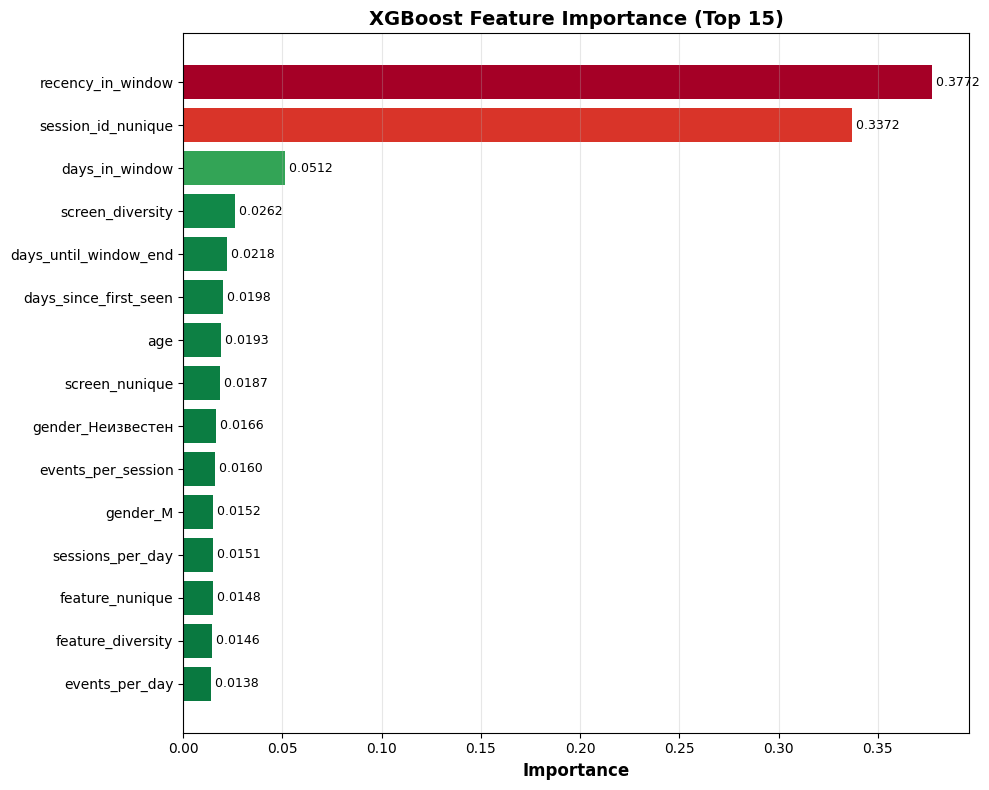

feature  importance
13      recency_in_window    0.377207
1      session_id_nunique    0.337194
5          days_in_window    0.051151
9        screen_diversity    0.026236
12  days_until_window_end    0.021826
11  days_since_first_seen    0.019840
14                    age    0.019261
2          screen_nunique    0.018705
17      gender_Неизвестен    0.016643
8      events_per_session    0.016024
16               gender_М    0.015215
7        sessions_per_day    0.015091
3         feature_nunique    0.014764
10      feature_diversity    0.014638
6          events_per_day    0.013823
0          event_dt_count    0.011463
15               gender_Ж    0.010917
4            action_count    0.000000

In [21]:
visualize_xgboost_importance()


LSTM ATTENTION VISUALIZATION
Creating sequences...
Loading model...
Extracting attention...

Generating visualizations...


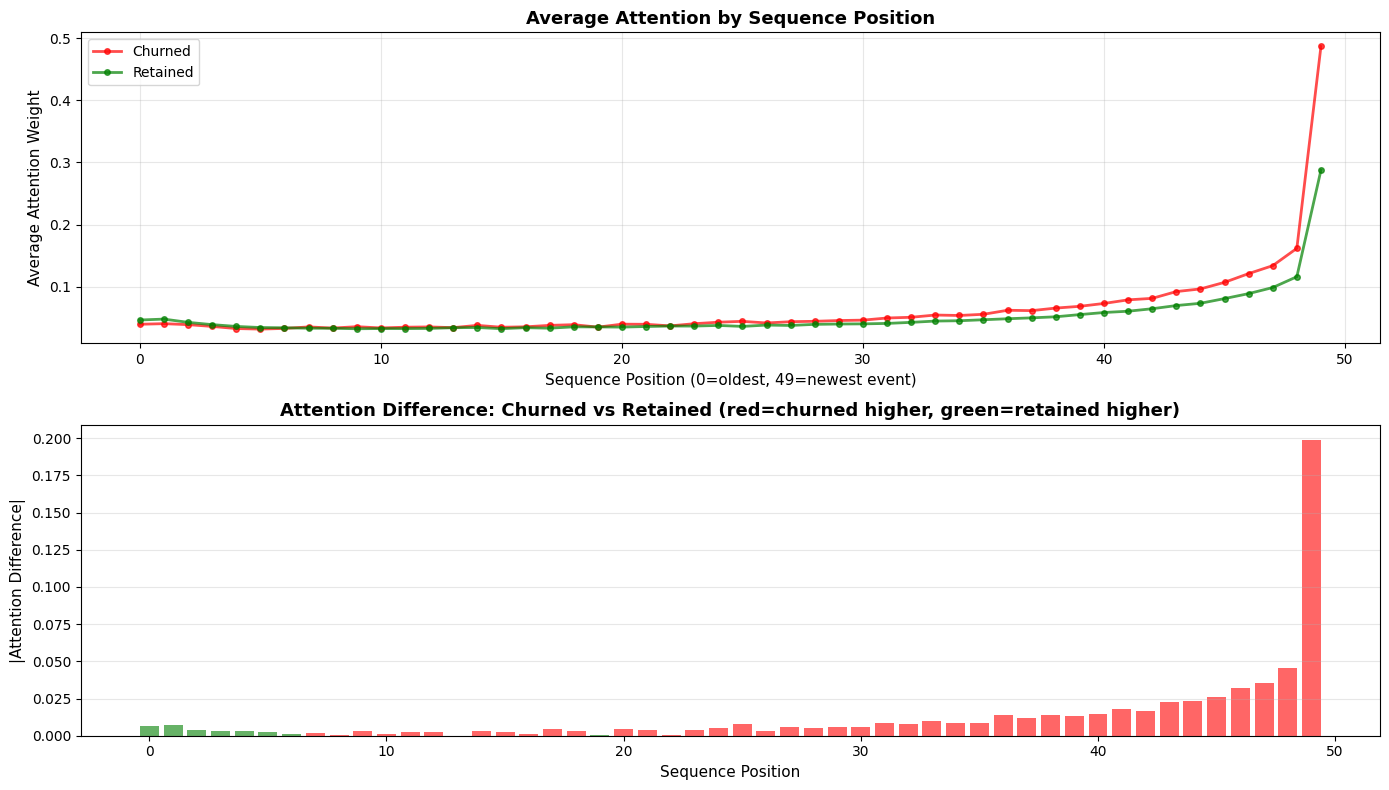

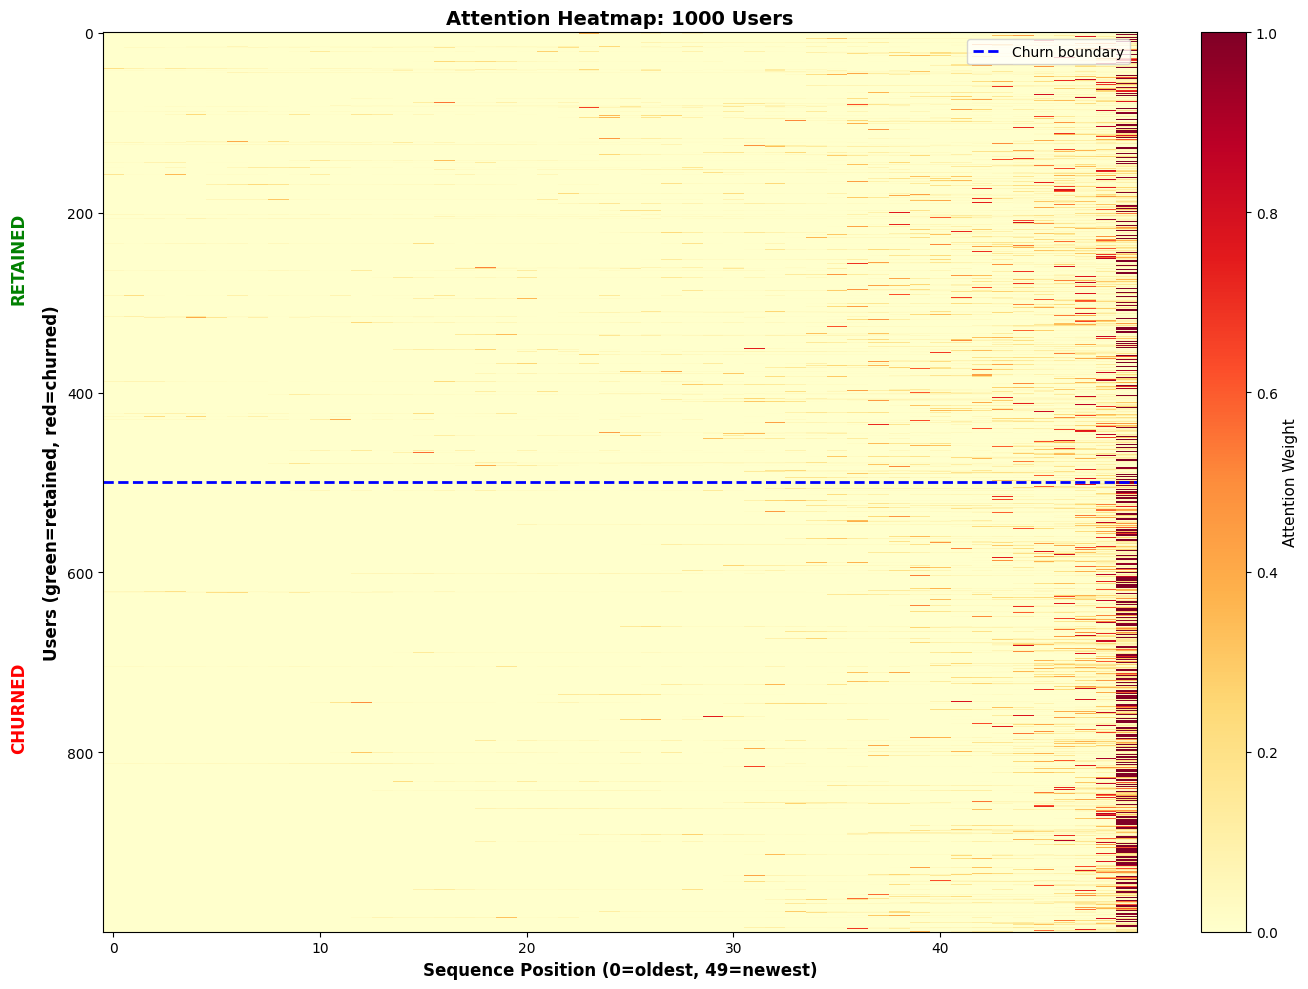

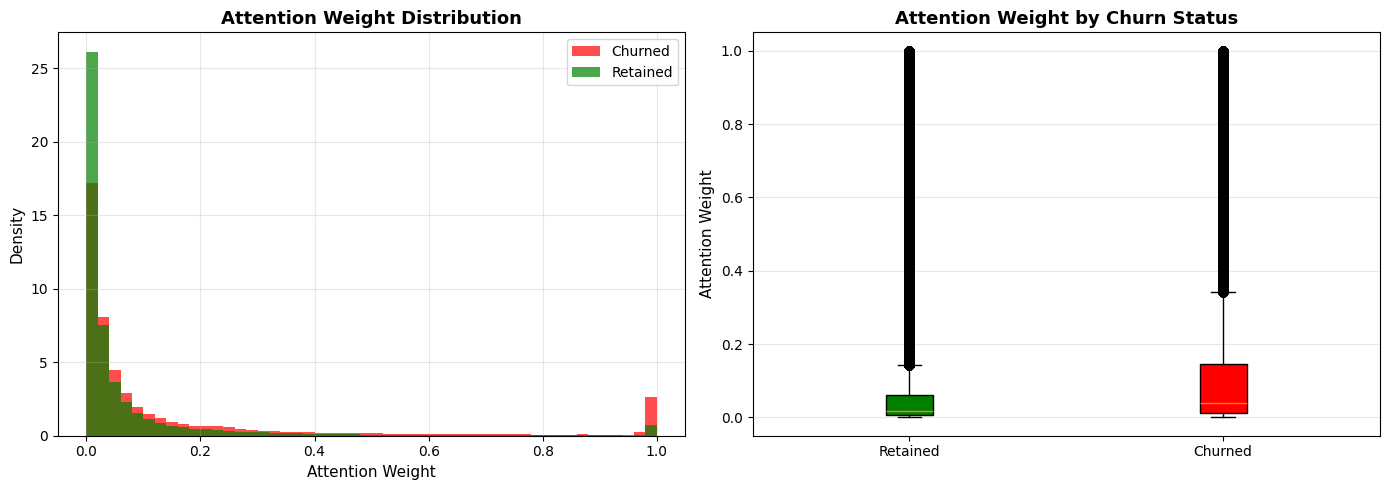


Attention Statistics:
Churned - Mean: 0.155560, Std: 0.263587
Retained - Mean: 0.079115, Std: 0.170422


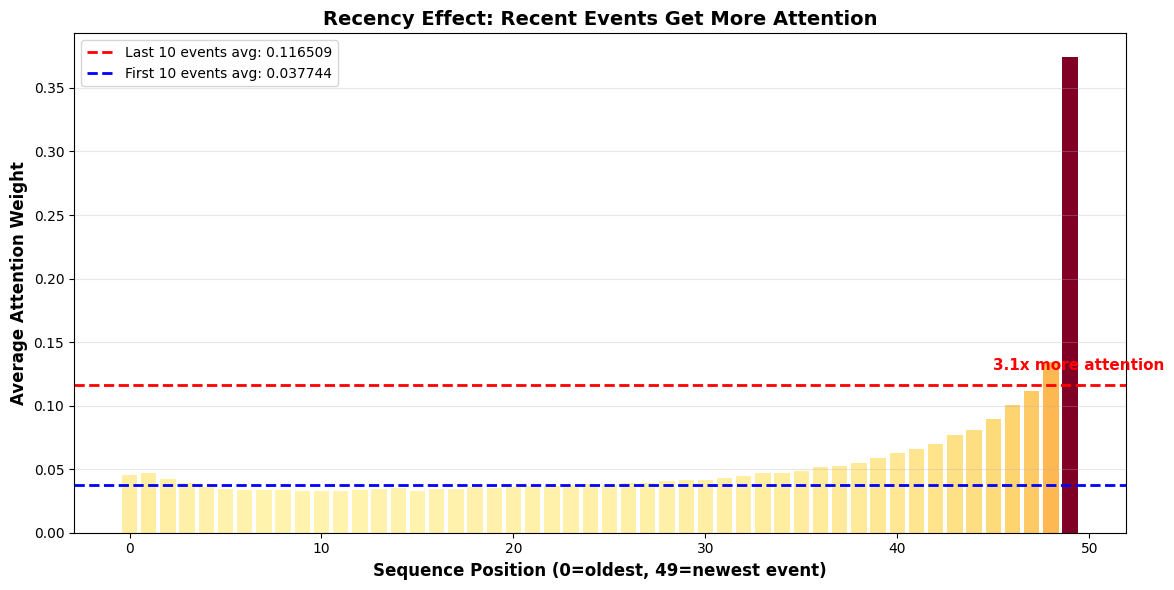


Recency Effect:
Last 10 events: 0.116509
First 10 events: 0.037744
Ratio: 3.09x

VISUALIZATIONS SAVED
- /content/group_project/feature_importance.png
- /content/group_project/attention_by_position.png
- /content/group_project/attention_heatmap.png
- /content/group_project/attention_distribution.png
- /content/group_project/attention_recency.png


In [22]:
visualize_lstm_attention()